In [1]:
# for making classic jupyter notebook wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [2]:
import os
import re
import matplotlib.pyplot as plt
import pickle
import torch
import sys
sys.path.insert(0, 'your-path-here/model-stealing-defenses/batch_training')
from utils import *
from defenses import get_Gty
from torchvision import datasets
from tqdm import tqdm
# import opacus  # recommended for the surrogate transfer experiments

# Parsing Results

The next cells that parse result files have nearby lines of code commented out. These are for selecting the experiments to parse and load into a results dictionary. These results are then used to create figures and numbers for the tables. To switch to a different set of experiments, you have to comment out the current one and uncomment
the one you want in all the relevant cells.

"ALL-ONES_10" corresponds to the GRAD^2 method in the paper.
"ALL-ONES_N" corresponds to the GRAD^2 method using a surrogate with early stopping after N epochs. These results are used in Figure 8 of the paper.

In [3]:
def get_epsilons(defense, return_strings=True):
    """
    Given the name of a defense, return the epsilons that you ran experiments on. Epsilon is a generalized budget
    parameter, corresponding to the L_1 perturbation budget for GRAD^2 and MAD (the else case). For other defenses,
    it corresponds to different quantities but is still called epsilon for convenience.
    """
    if return_strings:
        f = lambda x: str(x)
    else:
        f = lambda x: x
    
    if defense in ['None', 'None_argmax', 'None_vgg']:
        epsilons = [f(0.0)]
    elif defense == 'ReverseSigmoid':
        epsilons = [f(0.0), f(0.0025), f(0.005), f(0.01), f(0.02), f(0.04), f(0.08), f(0.16), f(0.32), f(0.64), f(1.28)]
    elif defense == 'AdaptiveMisinformation':
        epsilons = [f(0.0), f(0.05), f(0.1), f(0.15), f(0.2), f(0.25), f(0.3), f(0.35), f(0.4), f(0.45), f(0.5), f(0.55), f(0.6), f(0.65), f(0.7), f(0.75), f(0.8), f(0.85), f(0.9), f(0.95)]
    else:
        epsilons = [f(0.0), f(0.1), f(0.2), f(0.3), f(0.4), f(0.5), f(0.6), f(0.7), f(0.8), f(0.9), f(1.0)]
    
    return epsilons

In [4]:
# specify the transfer datasets in the results you want to collect
eval_data_to_transfer_data = {
    'cifar10': ['cifar100', 'imagenet_cifar10'],
    'cifar100': ['cifar10', 'imagenet_cifar100'],
    'cub200': ['caltech256', 'imagenet_cub200']
}

In [5]:
# Load all the posteriors created by get_queries scripts
# (Note: this is only used for computing the "effective epsilons"; all_posteriors is not used outside this cell)
print('Getting all_posteriors.')
all_posteriors = {}
for eval_data in ['cifar10', 'cifar100']:
    all_posteriors[eval_data] = {}
    for transfer_data in eval_data_to_transfer_data[eval_data]:
        all_posteriors[eval_data][transfer_data] = {}
#         for defense in ['None', 'Random', 'ReverseSigmoid', 'MAD', 'AdaptiveMisinformation', 'ALL-ONES_10', 'MIN-IP_10']:
#         for defense in ['None', 'None_argmax', 'ALL-ONES_10', 'ALL-ONES_10_argmax']:
        for defense in ['None', 'None_vgg', 'ALL-ONES_10', 'ALL-ONES_10_vgg', 'Random', 'Random_vgg']:
#         for defense in ['None', 'ALL-ONES_0', 'ALL-ONES_10', 'ALL-ONES_20', 'ALL-ONES_30', 'ALL-ONES_40', 'ALL-ONES_0_s1', 'ALL-ONES_10_s1', 'ALL-ONES_20_s1', 'ALL-ONES_30_s1', 'ALL-ONES_40_s1']:
    #     for defense in ['None', 'MAD', 'ALL-ONES_focused', 'ALL-ONES', 'ALL-ONES_10', 'ALL-ONES_10_focused1', 'ALL-ONES_10_focused2', 'ALL-ONES_10_focused3', 'ALL-ONES_10_focused4', 'ALL-ONES_10_focused5']:
            if '_argmax' in defense:
                defense_tmp = defense[:-len('_argmax')]
            elif '_vgg' in defense:
                defense_tmp = defense[:-len('_vgg')]
            else:
                defense_tmp = defense
            all_posteriors[eval_data][transfer_data][defense] = {}
            with open('your-path-here/model-stealing-defenses/outputs/generated_perturbations/{}_to_{}_{}.pkl'.format(transfer_data, eval_data, defense_tmp), 'rb') as f:
                posteriors = pickle.load(f)
            epsilons = get_epsilons(defense, return_strings=True)
            for epsilon in epsilons:
                if epsilon in posteriors:
                    all_posteriors[eval_data][transfer_data][defense][epsilon] = torch.FloatTensor(posteriors[epsilon])

# Get mapping from allowed epsilon to effective epsilon for fairer comparison
# Essentially, this converts the target epsilon into the true epsilon achieved, averaged across the query set.
# For MAD and GRAD^2, the target epsilon is not always achieved. This is because they also have to respect
# the simplex constraint, and sometimes this kicks in before the distance constraint.
# For other baselines where epsilon has a different meaning, effective epsilon converts this to an L_1 distance
# so that all methods can be compared on this metric (see "Metrics" section on page 7 of the paper).
print('Getting effective_epsilons.')
effective_epsilons = {}
for eval_data in ['cifar10', 'cifar100']:    
    effective_epsilons[eval_data] = {}
    for transfer_data in eval_data_to_transfer_data[eval_data]:
        effective_epsilons[eval_data][transfer_data] = {}

#         for defense in ['None', 'Random', 'ReverseSigmoid', 'MAD', 'AdaptiveMisinformation', 'ALL-ONES_10', 'MIN-IP_10']:
#         for defense in ['None', 'None_argmax', 'ALL-ONES_10', 'ALL-ONES_10_argmax']:
        for defense in ['None', 'None_vgg', 'ALL-ONES_10', 'ALL-ONES_10_vgg', 'Random', 'Random_vgg']:
#         for defense in ['None', 'ALL-ONES_0', 'ALL-ONES_10', 'ALL-ONES_20', 'ALL-ONES_30', 'ALL-ONES_40', 'ALL-ONES_0_s1', 'ALL-ONES_10_s1', 'ALL-ONES_20_s1', 'ALL-ONES_30_s1', 'ALL-ONES_40_s1']:
    #     for defense in ['None', 'MAD', 'ALL-ONES_focused', 'ALL-ONES', 'ALL-ONES_10', 'ALL-ONES_10_focused1', 'ALL-ONES_10_focused2', 'ALL-ONES_10_focused3', 'ALL-ONES_10_focused4', 'ALL-ONES_10_focused5']:
            if '_argmax' in defense:
                defense_tmp = defense[:-len('_argmax')]
            elif '_vgg' in defense:
                defense_tmp = defense[:-len('_vgg')]
            else:
                defense_tmp = defense
            effective_epsilons[eval_data][transfer_data][defense] = {}
            epsilons = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
            if defense == 'ReverseSigmoid':
                epsilons = ['0.0', '0.0025', '0.005', '0.01', '0.02', '0.04', '0.08', '0.16', '0.32', '0.64', '1.28']
            elif defense == 'AdaptiveMisinformation':
                epsilons = ['0.0', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35', '0.4', '0.45', '0.5',
                            '0.55', '0.6', '0.65', '0.7', '0.75', '0.8', '0.85', '0.9', '0.95']
            for epsilon in epsilons:
                if epsilon in all_posteriors[eval_data][transfer_data][defense]:
                    tmp = (all_posteriors[eval_data][transfer_data][defense_tmp][epsilon] - all_posteriors[eval_data][transfer_data]['None']['0.0']).abs().sum(1).mean(0).item()
                    effective_epsilons[eval_data][transfer_data][defense][epsilon] = tmp

print('Done.')

Getting all_posteriors.
Getting effective_epsilons.
Done.


In [4]:
# for some experiments, we don't want the distribution-aware results; run/modify this as needed
eval_data_to_transfer_data = {
    'cifar10': ['cifar100'],
    'cifar100': ['cifar10'],
}

In [9]:
# collect accuracies attained by the perturbed posteriors

defender_accuracies = {}
for eval_data in ['cifar10', 'cifar100']:
    defender_accuracies[eval_data] = {}
    print('====', eval_data)
    for transfer_data in eval_data_to_transfer_data[eval_data]:
        print('---', transfer_data)
        defender_accuracies[eval_data][transfer_data] = {}
        for defense in ['None', 'Random', 'ReverseSigmoid', 'AdaptiveMisinformation', 'MAD', 'ALL-ONES_10']:
#         for defense in ['None', 'ALL-ONES_0', 'ALL-ONES_10', 'ALL-ONES_20', 'ALL-ONES_30', 'ALL-ONES_40', 'ALL-ONES_0_s1', 'ALL-ONES_10_s1', 'ALL-ONES_20_s1', 'ALL-ONES_30_s1', 'ALL-ONES_40_s1']:
    #     for defense in ['None', 'MAD', 'ALL-ONES_focused', 'ALL-ONES', 'ALL-ONES_10', 'ALL-ONES_10_focused1', 'ALL-ONES_10_focused2', 'ALL-ONES_10_focused3', 'ALL-ONES_10_focused4', 'ALL-ONES_10_focused5']:
            print(defense)
            defender_accuracies[eval_data][transfer_data][defense] = {}
            with open('your-path-here/model-stealing-defenses/outputs/generated_perturbations/{}_to_{}_{}_val.pkl'.format(
                transfer_data, eval_data, defense), 'rb') as f:
                posteriors = pickle.load(f)

            data, _ = load_data(eval_data, train=False)
            if eval_data == 'cub200':
                targets = [data.data.target.iloc[i] - 1 for i in range(len(data))]
            else:
                targets = data.targets

            epsilons = get_epsilons(defense, return_strings=True)
            for epsilon in epsilons:
                if epsilon in posteriors:
                    post = torch.FloatTensor(posteriors[epsilon])
                    pred = torch.argmax(post, dim=1)
                    correct = (pred == torch.FloatTensor(targets)).float()
                    defender_accuracies[eval_data][transfer_data][defense][epsilon] = correct.mean()

==== cifar10
--- cifar100
None
Files already downloaded and verified
Random
Files already downloaded and verified
ReverseSigmoid
Files already downloaded and verified
AdaptiveMisinformation
Files already downloaded and verified
MAD
Files already downloaded and verified
ALL-ONES_10
Files already downloaded and verified
==== cifar100
--- cifar10
None
Files already downloaded and verified
Random
Files already downloaded and verified
ReverseSigmoid
Files already downloaded and verified
AdaptiveMisinformation
Files already downloaded and verified
MAD
Files already downloaded and verified
ALL-ONES_10
Files already downloaded and verified


In [6]:
# eval_data_to_transfer_data = {
#     'cifar10': ['cifar100', 'imagenet_cifar10'],
#     'cifar100': ['cifar10', 'imagenet_cifar100'],
#     'cub200': ['caltech256', 'imagenet_cub200']
# }
eval_data_to_transfer_data = {
    'cifar10': ['cifar100'],
    'cifar100': ['cifar10'],
}
# eval_data_to_transfer_data = {
#     'cifar100': ['imagenet_cifar100'],
# }


results = {}


for eval_data in ['cifar10', 'cifar100']:    
    results[eval_data] = {}
    for transfer_data in eval_data_to_transfer_data[eval_data]:
        results[eval_data][transfer_data] = {}
        # teacher accuracy is parsed from the final results in the stdout training log; faster than recomputing
        with open('./condor_outputs/teacher_outputs/train_teacher_{}.stdout'.format(eval_data), 'r') as f:
            text = f.read()
        try:
            results[eval_data][transfer_data]['teacher'] = float(re.findall('Final:: .*? Test Acc: (.*)', text)[0])
        except:
            print('problem getting teacher results:', eval_data, transfer_data)

        # non-oracle results
#         for defense in ['None', 'Random', 'ReverseSigmoid', 'AdaptiveMisinformation', 'MAD', 'ALL-ONES_10', 'MIN-IP_10']:
#         for defense in ['None', 'None_argmax', 'ALL-ONES_10', 'ALL-ONES_10_argmax']:
        for defense in ['None', 'None_vgg', 'ALL-ONES_10', 'ALL-ONES_10_vgg', 'Random', 'Random_vgg']:
#         for defense in ['None', 'ALL-ONES_0', 'ALL-ONES_10', 'ALL-ONES_20', 'ALL-ONES_30', 'ALL-ONES_40', 'ALL-ONES_0_s1', 'ALL-ONES_10_s1', 'ALL-ONES_20_s1', 'ALL-ONES_30_s1', 'ALL-ONES_40_s1']:
    #     for defense in ['None', 'MAD', 'ALL-ONES_focused', 'ALL-ONES', 'ALL-ONES_10', 'ALL-ONES_10_focused1', 'ALL-ONES_10_focused2', 'ALL-ONES_10_focused3', 'ALL-ONES_10_focused4', 'ALL-ONES_10_focused5']:
            results[eval_data][transfer_data][defense] = {'e_eps': [], 'd_err': [],
                                                          'd_calib_err': [], 'd_avg_err': [], 'a_err': []}
            epsilons = get_epsilons(defense, return_strings=False)
            for epsilon in epsilons:
    #             if epsilon == 0.2 and defense == 'ALL-ONES_10':
    #                  continue  # for skipping over experiments that didn't finish
                exp_name = f'{transfer_data}_to_{eval_data}_{defense}_eps{epsilon}.stdout'
                with open('./condor_outputs/adversary_outputs/train_adversary_' + exp_name, 'r') as f:
                    text = f.read()
                e_epsilon = effective_epsilons[eval_data][transfer_data][defense][str(epsilon)]
                defender_acc = defender_accuracies[eval_data][transfer_data][defense][str(epsilon)]
                results[eval_data][transfer_data][defense]['e_eps'].append(e_epsilon)
                results[eval_data][transfer_data][defense]['d_err'].append(1 - defender_acc)
                results[eval_data][transfer_data][defense]['a_err'].append(1 - float(re.findall('Final:: .*? Test Acc: (.*)', text)[0]))

problem getting teacher results: cifar10 cifar100
problem getting teacher results: cifar100 cifar10


## Now begin plotting

KeyError: 'cifar10'

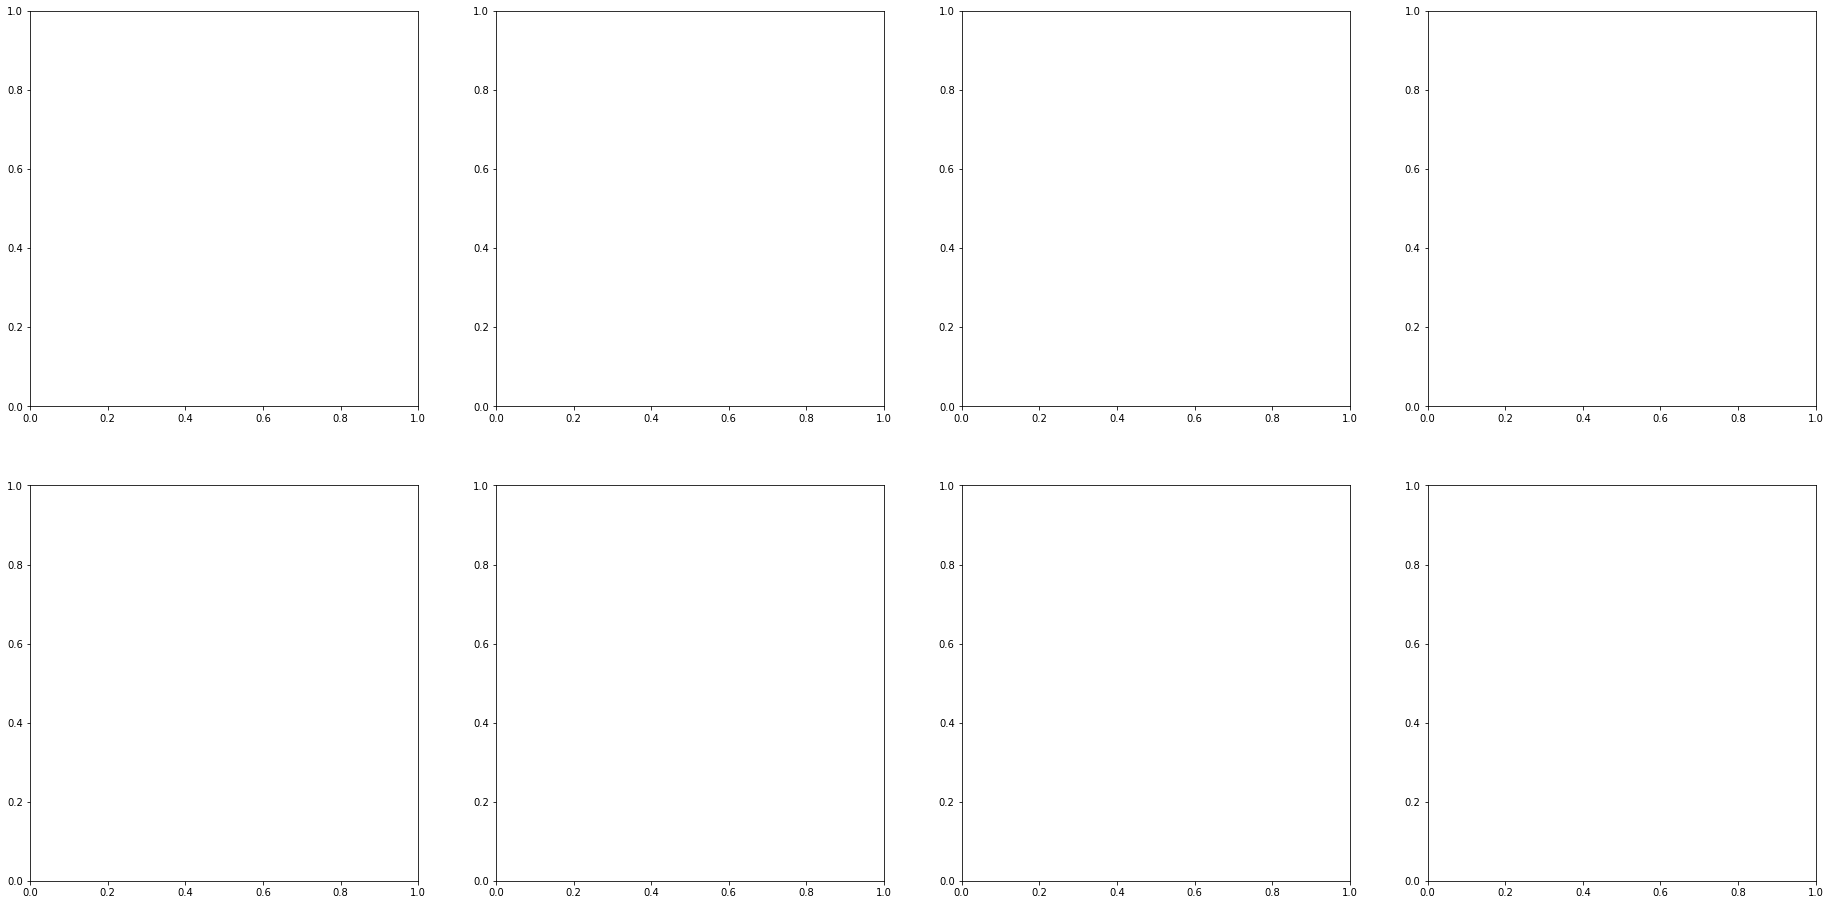

In [269]:
dataset_to_string = {
    'cifar10': 'CIFAR-10',
    'cifar100': 'CIFAR-100',
    'cub200': 'CUB200',
    'caltech256': 'Caltech-256',
    'imagenet_cifar10': 'ImageNet-C10',
    'imagenet_cifar100': 'ImageNet-C100',
    'imagenet_cub200': 'ImageNet-CUB200'
}
label_dict = {
    'None': 'No Defense',
    'Random': 'Random',
    'ReverseSigmoid': 'Reverse Sigmoid',
    'AdaptiveMisinformation': 'AM',
    'MAD': 'MAD',
    'ALL-ONES_10': r'GRAD${}^2$ (Ours)'
}
color_dict = {
    'None': 'black',
    'Random': '#E79556',
    'ReverseSigmoid': 'brown',
    'AdaptiveMisinformation': '#9043C3',
    'MAD': '#F15757',
    'ALL-ONES_10': 'royalblue'
}

defense_list = ['ALL-ONES_10', 'MAD', 'AdaptiveMisinformation',
                'ReverseSigmoid', 'Random', 'None']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(32, 16))

for col_idx, eval_data in enumerate(['cifar10', 'cifar10', 'cifar100', 'cub200']):
    if col_idx == 0:
        transfer_data = eval_data_to_transfer_data[eval_data][0]  # knowledge-limited adv
    else:
        transfer_data = eval_data_to_transfer_data[eval_data][1]  # knowledgeable adv
    for row_idx, metric in enumerate(['d_err', 'e_eps']):
        ax = axes[row_idx, col_idx]
        for i, defense in enumerate(defense_list):
            if defense == 'teacher':
                pass
                #plt.plot(0, results[eval_data]['teacher'], 'o', label='teacher')
            elif defense == 'None':
                if metric == 'd_err':
                    tmp = [100 * x for x in results[eval_data][transfer_data][defense][metric]]
                else:
                    tmp = results[eval_data][transfer_data][defense][metric]
                ax.plot(tmp,
                        [100 * x for x in results[eval_data][transfer_data][defense]['a_err']],
                        'o', label=label_dict[defense], c=color_dict[defense], zorder=100, markersize=8)
            else:
                if metric == 'd_err':
                    tmp = [100 * x for x in results[eval_data][transfer_data][defense][metric]]
                else:
                    tmp = results[eval_data][transfer_data][defense][metric]
                ax.plot(tmp,
                        [100 * x for x in results[eval_data][transfer_data][defense]['a_err']],
                        '--' if '_s1' in defense else '-', label=label_dict[defense],
                        lw=6 if defense == 'ALL-ONES_10' else 5, c=color_dict[defense],
                        zorder=100 if defense == 'ALL-ONES_10' else 0)

        ax.tick_params(axis='both', which='major', labelsize=20)
                
        if col_idx == row_idx == 0:
            ax.legend(fontsize=25)
        if metric == 'd_err':
            ax.set_xlabel('Defender\'s Classification Error', fontsize=27)
        elif metric == 'd_calib_err':
            ax.set_xlabel('Defender\'s Calibration Error', fontsize=27)
        elif metric == 'd_avg_err':
            ax.set_xlabel('Defender\'s Combined Error', fontsize=27)
        elif metric == 'e_eps':
            ax.set_xlabel(r'$\ell_1$ Perturbation Budget', fontsize=27)
        
        if col_idx == 0:
            ax.set_ylabel('Adversary\'s Classification Error', fontsize=27)
        
        if row_idx == 0:
            ax.set_title(r'{} $\to$ {}'.format(dataset_to_string[transfer_data],
                                               dataset_to_string[eval_data]), fontsize=30)
        
        if metric == 'd_err':
            tmp1 = 100 * results[eval_data][transfer_data]['None'][metric][0]
        else:
            tmp1 = results[eval_data][transfer_data]['None'][metric][0]
        tmp2 = 100 * results[eval_data][transfer_data]['None']['a_err'][0]
        if metric == 'd_err':
            if eval_data == 'cifar10':
                ax.set_xlim(tmp1 * 0.95, tmp1 + 100*0.045)
                ax.set_ylim(tmp2 * 0.9, tmp2 * 2.6)
            elif eval_data == 'cifar100':
                ax.set_xlim(tmp1 * 0.985, tmp1 + 100*0.045)
                ax.set_ylim(tmp2 * 0.95, tmp2 * 1.5)
            elif eval_data == 'cub200':
                ax.set_xlim(tmp1 * 0.985, tmp1 + 100*0.045)
                ax.set_ylim(tmp2 * 0.95, tmp2 * 1.65)
        elif metric == 'e_eps':
            if eval_data == 'cifar10':
                if col_idx == 0:
                    ax.set_xlim(-0.03, 0.8)
                    ax.set_ylim(tmp2 * 0.95, tmp2 * 2.5)
                else:
                    ax.set_xlim(-0.03, 0.8)
                    ax.set_ylim(tmp2 * 0.9, tmp2 * 3.2)
            elif eval_data == 'cifar100':
                ax.set_xlim(-0.03, 0.8)
                ax.set_ylim(tmp2 * 0.98, tmp2 * 1.65)
            elif eval_data == 'cub200':
                ax.set_xlim(-0.03, 0.8)
                ax.set_ylim(tmp2 * 0.98, tmp2 * 1.6)

plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=3.0)
plt.savefig('./figures/plots1.pdf', bbox_inches='tight')
plt.show()

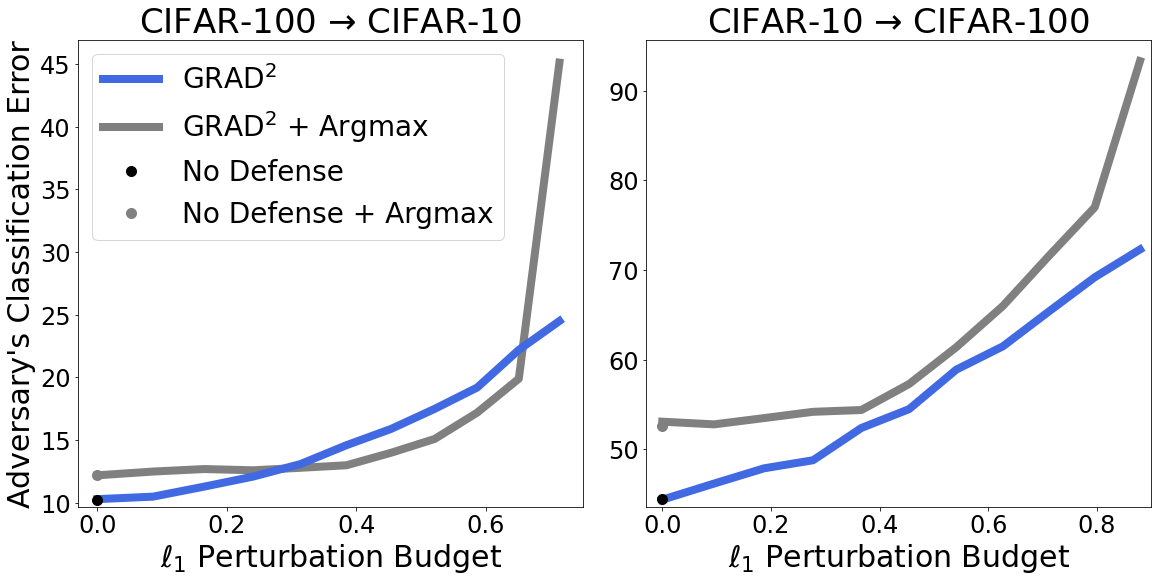

In [19]:
dataset_to_string = {
    'cifar10': 'CIFAR-10',
    'cifar100': 'CIFAR-100',
    'cub200': 'CUB200',
    'caltech256': 'Caltech-256',
    'imagenet_cifar10': 'ImageNet-C10',
    'imagenet_cifar100': 'ImageNet-C100',
    'imagenet_cub200': 'ImageNet-CUB200'
}
label_dict = {
    'None': 'No Defense',
    'None_argmax': 'No Defense + Argmax',
    'ALL-ONES_10': r'GRAD${}^2$',
    'ALL-ONES_10_argmax': r'GRAD${}^2$ + Argmax'
}
color_dict = {
    'None': 'black',
    'None_argmax': 'gray',
    'ALL-ONES_10': 'royalblue',
    'ALL-ONES_10_argmax': 'gray'
}

defense_list = ['ALL-ONES_10', 'ALL-ONES_10_argmax', 'None', 'None_argmax']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

for col_idx, eval_data in enumerate(['cifar10', 'cifar100']):
    transfer_data = eval_data_to_transfer_data[eval_data][0]  # knowledge-limited adv
    for row_idx, metric in enumerate(['e_eps']):
        ax = axes[col_idx]
        for i, defense in enumerate(defense_list):
            if defense == 'teacher':
                pass
                #plt.plot(0, results[eval_data]['teacher'], 'o', label='teacher')
            elif defense in ['None', 'None_argmax']:
                if metric == 'd_err':
                    tmp = [100 * x for x in results[eval_data][transfer_data][defense][metric]]
                else:
                    tmp = results[eval_data][transfer_data][defense][metric]
                ax.plot(tmp,
                        [100 * x for x in results[eval_data][transfer_data][defense]['a_err']],
                        'o', label=label_dict[defense], c=color_dict[defense], zorder=100, markersize=10)
            else:
                if metric == 'd_err':
                    tmp = [100 * x for x in results[eval_data][transfer_data][defense][metric]]
                else:
                    tmp = results[eval_data][transfer_data][defense][metric]
                ax.plot(tmp,
                        [100 * x for x in results[eval_data][transfer_data][defense]['a_err']],
                        '--' if '_s1' in defense else '-', label=label_dict[defense],
                        lw=8 if defense == 'ALL-ONES_10' else 8, c=color_dict[defense],
                        zorder=100 if defense == 'ALL-ONES_10' else 0)

        ax.tick_params(axis='both', which='major', labelsize=24)
                
        if col_idx == row_idx == 0:
            ax.legend(fontsize=28)
        if metric == 'd_err':
            ax.set_xlabel('Defender\'s Classification Error', fontsize=3)
        elif metric == 'd_calib_err':
            ax.set_xlabel('Defender\'s Calibration Error', fontsize=27)
        elif metric == 'd_avg_err':
            ax.set_xlabel('Defender\'s Combined Error', fontsize=27)
        elif metric == 'e_eps':
            ax.set_xlabel(r'$\ell_1$ Perturbation Budget', fontsize=30)
        
        if col_idx == 0:
            ax.set_ylabel('Adversary\'s Classification Error', fontsize=30)
        
        if row_idx == 0:
            ax.set_title(r'{} $\to$ {}'.format(dataset_to_string[transfer_data],
                                               dataset_to_string[eval_data]), fontsize=34)
        
        if metric == 'd_err':
            tmp1 = 100 * results[eval_data][transfer_data]['None'][metric][0]
        else:
            tmp1 = results[eval_data][transfer_data]['None'][metric][0]
        tmp2 = 100 * results[eval_data][transfer_data]['None']['a_err'][0]
        if metric == 'd_err':
            if eval_data == 'cifar10':
                ax.set_xlim(tmp1 * 0.95, tmp1 + 100*0.045)
                ax.set_ylim(tmp2 * 0.9, tmp2 * 2.6)
            elif eval_data == 'cifar100':
                ax.set_xlim(tmp1 * 0.985, tmp1 + 100*0.045)
                ax.set_ylim(tmp2 * 0.95, tmp2 * 1.5)
            elif eval_data == 'cub200':
                ax.set_xlim(tmp1 * 0.985, tmp1 + 100*0.045)
                ax.set_ylim(tmp2 * 0.95, tmp2 * 1.65)
        elif metric == 'e_eps':
            if eval_data == 'cifar10':
                if col_idx == 0:
                    ax.set_xlim(-0.03, 0.75)
                    ax.set_ylim(tmp2 * 0.95, tmp2 * 4.6)
                else:
                    ax.set_xlim(-0.03, 0.75)
                    ax.set_ylim(tmp2 * 0.9, tmp2 * 3.5)
            elif eval_data == 'cifar100':
                ax.set_xlim(-0.03, 0.9)
                ax.set_ylim(tmp2 * 0.98, tmp2 * 2.15)
            elif eval_data == 'cub200':
                ax.set_xlim(-0.03, 0.8)
                ax.set_ylim(tmp2 * 0.98, tmp2 * 1.6)

plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=3.0)
# plt.savefig('./figures/argmax.pdf', bbox_inches='tight')
plt.show()

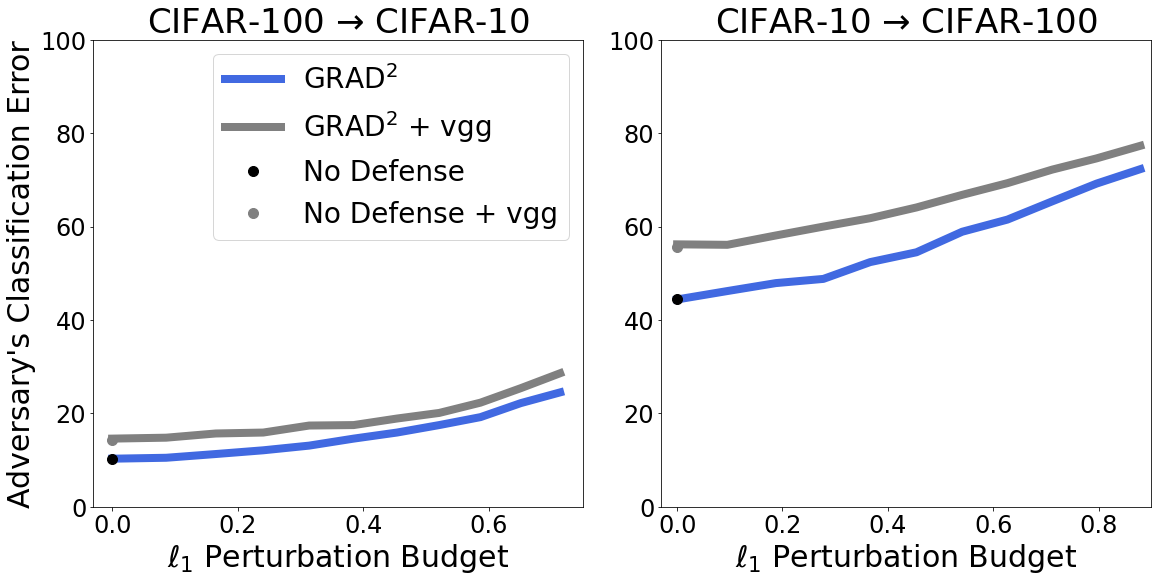

In [9]:
dataset_to_string = {
    'cifar10': 'CIFAR-10',
    'cifar100': 'CIFAR-100',
    'cub200': 'CUB200',
    'caltech256': 'Caltech-256',
    'imagenet_cifar10': 'ImageNet-C10',
    'imagenet_cifar100': 'ImageNet-C100',
    'imagenet_cub200': 'ImageNet-CUB200'
}
label_dict = {
    'None': 'No Defense',
    'None_vgg': 'No Defense + vgg',
    'ALL-ONES_10': r'GRAD${}^2$',
    'ALL-ONES_10_vgg': r'GRAD${}^2$ + vgg',
    'Random': 'Random',
    'Random_vgg': 'Random + vgg'
}
color_dict = {
    'None': 'black',
    'None_vgg': 'gray',
    'ALL-ONES_10': 'royalblue',
    'ALL-ONES_10_vgg': 'gray',
    'Random': 'royalblue',
    'Random_vgg': 'gray'
}

defense_list = ['ALL-ONES_10', 'ALL-ONES_10_vgg', 'None', 'None_vgg']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

for col_idx, eval_data in enumerate(['cifar10', 'cifar100']):
    transfer_data = eval_data_to_transfer_data[eval_data][0]  # knowledge-limited adv
    for row_idx, metric in enumerate(['e_eps']):
        ax = axes[col_idx]
        for i, defense in enumerate(defense_list):
            if defense == 'teacher':
                pass
                #plt.plot(0, results[eval_data]['teacher'], 'o', label='teacher')
            elif defense in ['None', 'None_vgg']:
                if metric == 'd_err':
                    tmp = [100 * x for x in results[eval_data][transfer_data][defense][metric]]
                else:
                    tmp = results[eval_data][transfer_data][defense][metric]
                ax.plot(tmp,
                        [100 * x for x in results[eval_data][transfer_data][defense]['a_err']],
                        'o', label=label_dict[defense], c=color_dict[defense], zorder=100, markersize=10)
            else:
                if metric == 'd_err':
                    tmp = [100 * x for x in results[eval_data][transfer_data][defense][metric]]
                else:
                    tmp = results[eval_data][transfer_data][defense][metric]
                ax.plot(tmp,
                        [100 * x for x in results[eval_data][transfer_data][defense]['a_err']],
                        '--' if '_s1' in defense else '-', label=label_dict[defense],
                        lw=8 if defense == 'ALL-ONES_10' else 8, c=color_dict[defense],
                        zorder=100 if defense == 'ALL-ONES_10' else 0)

        ax.tick_params(axis='both', which='major', labelsize=24)
                
        if col_idx == row_idx == 0:
            ax.legend(fontsize=28)
        if metric == 'd_err':
            ax.set_xlabel('Defender\'s Classification Error', fontsize=3)
        elif metric == 'd_calib_err':
            ax.set_xlabel('Defender\'s Calibration Error', fontsize=27)
        elif metric == 'd_avg_err':
            ax.set_xlabel('Defender\'s Combined Error', fontsize=27)
        elif metric == 'e_eps':
            ax.set_xlabel(r'$\ell_1$ Perturbation Budget', fontsize=30)
        
        if col_idx == 0:
            ax.set_ylabel('Adversary\'s Classification Error', fontsize=30)
        
        if row_idx == 0:
            ax.set_title(r'{} $\to$ {}'.format(dataset_to_string[transfer_data],
                                               dataset_to_string[eval_data]), fontsize=34)
        
        if metric == 'd_err':
            tmp1 = 100 * results[eval_data][transfer_data]['None'][metric][0]
        else:
            tmp1 = results[eval_data][transfer_data]['None'][metric][0]
        tmp2 = 100 * results[eval_data][transfer_data]['None']['a_err'][0]
        if metric == 'd_err':
            if eval_data == 'cifar10':
                ax.set_xlim(tmp1 * 0.95, tmp1 + 100*0.045)
                ax.set_ylim(tmp2 * 0.9, tmp2 * 2.6)
            elif eval_data == 'cifar100':
                ax.set_xlim(tmp1 * 0.985, tmp1 + 100*0.045)
                ax.set_ylim(tmp2 * 0.95, tmp2 * 1.5)
            elif eval_data == 'cub200':
                ax.set_xlim(tmp1 * 0.985, tmp1 + 100*0.045)
                ax.set_ylim(tmp2 * 0.95, tmp2 * 1.65)
        elif metric == 'e_eps':
            if eval_data == 'cifar10':
                if col_idx == 0:
                    ax.set_xlim(-0.03, 0.75)
                    ax.set_ylim(tmp2 * 0.95, tmp2 * 4.6)
                else:
                    ax.set_xlim(-0.03, 0.75)
                    ax.set_ylim(tmp2 * 0.9, tmp2 * 3.5)
            elif eval_data == 'cifar100':
                ax.set_xlim(-0.03, 0.9)
                ax.set_ylim(tmp2 * 0.98, tmp2 * 2.15)
            elif eval_data == 'cub200':
                ax.set_xlim(-0.03, 0.8)
                ax.set_ylim(tmp2 * 0.98, tmp2 * 1.6)
        ax.set_ylim(0, 100)
plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=3.0)
plt.savefig('./figures/vgg.pdf', bbox_inches='tight')
plt.show()

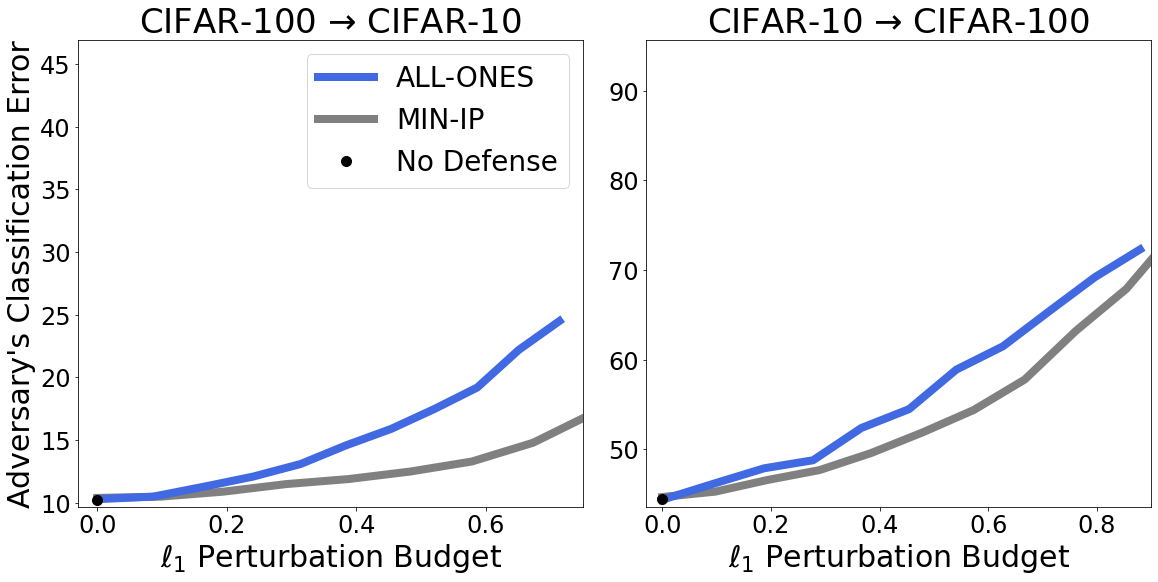

In [95]:
# coordinated defense analysis

dataset_to_string = {
    'cifar10': 'CIFAR-10',
    'cifar100': 'CIFAR-100',
    'cub200': 'CUB200',
    'caltech256': 'Caltech-256',
    'imagenet_cifar10': 'ImageNet-C10',
    'imagenet_cifar100': 'ImageNet-C100',
    'imagenet_cub200': 'ImageNet-CUB200'
}
label_dict = {
    'None': 'No Defense',
    'ALL-ONES_10': r'Coordinated Defense',
    'MIN-IP_10': r'Uncoordinated Defense',
}
color_dict = {
    'None': 'black',
    'ALL-ONES_10': 'royalblue',
    'MIN-IP_10': 'gray',
}

defense_list = ['ALL-ONES_10', 'MIN-IP_10', 'None']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

for col_idx, eval_data in enumerate(['cifar10', 'cifar100']):
    transfer_data = eval_data_to_transfer_data[eval_data][0]  # knowledge-limited adv
    for row_idx, metric in enumerate(['e_eps']):
        ax = axes[col_idx]
        for i, defense in enumerate(defense_list):
            if defense == 'teacher':
                pass
                #plt.plot(0, results[eval_data]['teacher'], 'o', label='teacher')
            elif defense in ['None', 'None_argmax']:
                if metric == 'd_err':
                    tmp = [100 * x for x in results[eval_data][transfer_data][defense][metric]]
                else:
                    tmp = results[eval_data][transfer_data][defense][metric]
                ax.plot(tmp,
                        [100 * x for x in results[eval_data][transfer_data][defense]['a_err']],
                        'o', label=label_dict[defense], c=color_dict[defense], zorder=100, markersize=10)
            else:
                if metric == 'd_err':
                    tmp = [100 * x for x in results[eval_data][transfer_data][defense][metric]]
                else:
                    tmp = results[eval_data][transfer_data][defense][metric]
                ax.plot(tmp,
                        [100 * x for x in results[eval_data][transfer_data][defense]['a_err']],
                        '--' if '_s1' in defense else '-', label=label_dict[defense],
                        lw=8 if defense == 'ALL-ONES_10' else 8, c=color_dict[defense],
                        zorder=100 if defense == 'ALL-ONES_10' else 0)

        ax.tick_params(axis='both', which='major', labelsize=24)
                
        if col_idx == row_idx == 0:
            ax.legend(fontsize=28)
        if metric == 'd_err':
            ax.set_xlabel('Defender\'s Classification Error', fontsize=3)
        elif metric == 'd_calib_err':
            ax.set_xlabel('Defender\'s Calibration Error', fontsize=27)
        elif metric == 'd_avg_err':
            ax.set_xlabel('Defender\'s Combined Error', fontsize=27)
        elif metric == 'e_eps':
            ax.set_xlabel(r'$\ell_1$ Perturbation Budget', fontsize=30)
        
        if col_idx == 0:
            ax.set_ylabel('Adversary\'s Classification Error', fontsize=30)
        
        if row_idx == 0:
            ax.set_title(r'{} $\to$ {}'.format(dataset_to_string[transfer_data],
                                               dataset_to_string[eval_data]), fontsize=34)
        
        if metric == 'd_err':
            tmp1 = 100 * results[eval_data][transfer_data]['None'][metric][0]
        else:
            tmp1 = results[eval_data][transfer_data]['None'][metric][0]
        tmp2 = 100 * results[eval_data][transfer_data]['None']['a_err'][0]
        if metric == 'd_err':
            if eval_data == 'cifar10':
                ax.set_xlim(tmp1 * 0.95, tmp1 + 100*0.045)
                ax.set_ylim(tmp2 * 0.9, tmp2 * 2.6)
            elif eval_data == 'cifar100':
                ax.set_xlim(tmp1 * 0.985, tmp1 + 100*0.045)
                ax.set_ylim(tmp2 * 0.95, tmp2 * 1.5)
            elif eval_data == 'cub200':
                ax.set_xlim(tmp1 * 0.985, tmp1 + 100*0.045)
                ax.set_ylim(tmp2 * 0.95, tmp2 * 1.65)
        elif metric == 'e_eps':
            if eval_data == 'cifar10':
                if col_idx == 0:
                    ax.set_xlim(-0.03, 0.75)
                    ax.set_ylim(tmp2 * 0.95, tmp2 * 4.6)
                else:
                    ax.set_xlim(-0.03, 0.75)
                    ax.set_ylim(tmp2 * 0.9, tmp2 * 3.5)
            elif eval_data == 'cifar100':
                ax.set_xlim(-0.03, 0.9)
                ax.set_ylim(tmp2 * 0.98, tmp2 * 2.15)
            elif eval_data == 'cub200':
                ax.set_xlim(-0.03, 0.8)
                ax.set_ylim(tmp2 * 0.98, tmp2 * 1.6)

plt.tight_layout(pad=0.4, w_pad=2.5, h_pad=3.0)
plt.savefig('./figures/coordination.pdf', bbox_inches='tight')
plt.show()

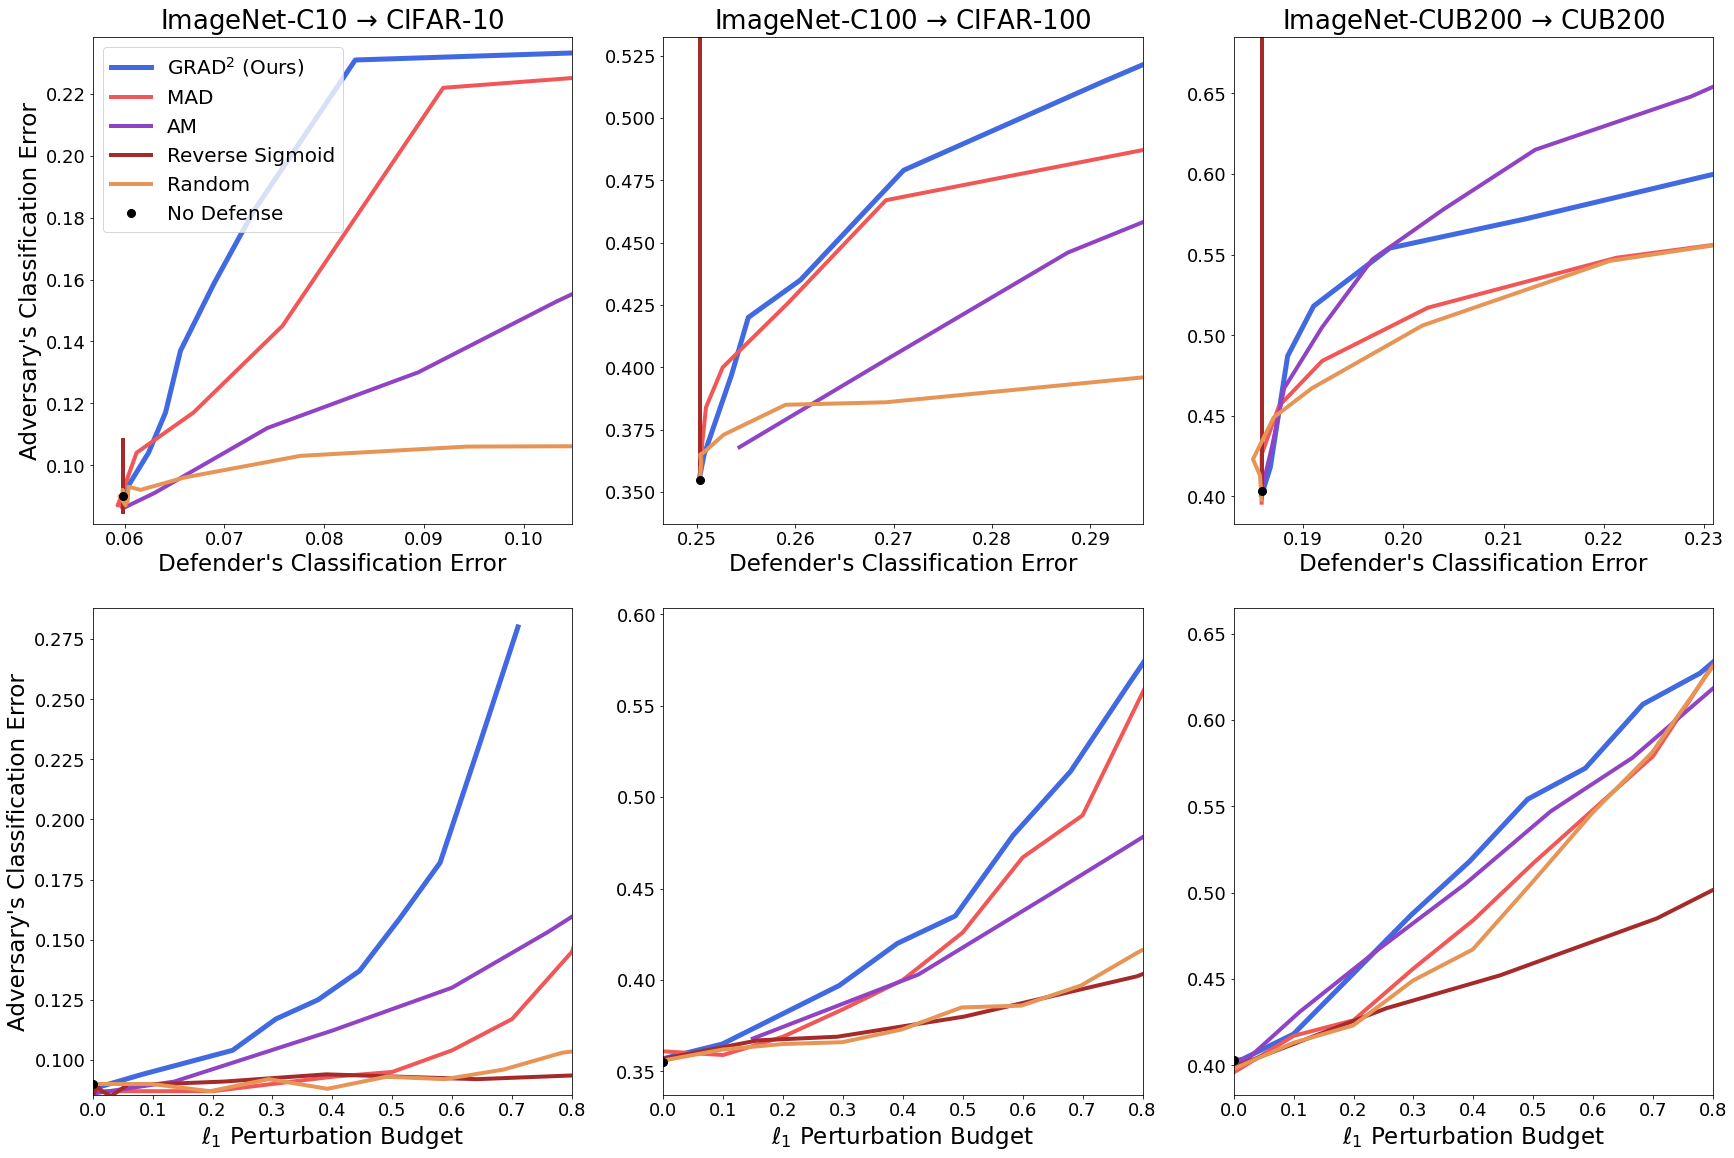

In [125]:
label_dict = {
    'None': 'No Defense',
    'Random': 'Random',
    'ReverseSigmoid': 'Reverse Sigmoid',
    'AdaptiveMisinformation': 'AM',
    'MAD': 'MAD',
    'ALL-ONES_10': r'GRAD${}^2$ (Ours)'
}
color_dict = {
    'None': 'black',
    'Random': '#E79556',
    'ReverseSigmoid': 'brown',
    'AdaptiveMisinformation': '#9043C3',
    'MAD': '#F15757',
    'ALL-ONES_10': 'royalblue'
}

defense_list = ['ALL-ONES_10', 'MAD', 'AdaptiveMisinformation',
                'ReverseSigmoid', 'Random', 'None']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))

for col_idx, eval_data in enumerate(['cifar10', 'cifar100', 'cub200']):
    for row_idx, metric in enumerate(['d_err', 'e_eps']):
        ax = axes[row_idx, col_idx]
        for i, defense in enumerate(defense_list):
            if defense == 'teacher':
                pass
                #plt.plot(0, results[eval_data]['teacher'], 'o', label='teacher')
            elif defense == 'None':
                ax.plot(results[eval_data][defense][metric],
                        results[eval_data][defense]['a_err'],
                        'o', label=label_dict[defense], c=color_dict[defense], zorder=100, markersize=8)
            else:
                ax.plot(results[eval_data][defense][metric],
                        results[eval_data][defense]['a_err'],
                        '--' if '_s1' in defense else '-', label=label_dict[defense],
                        lw=5 if defense == 'ALL-ONES_10' else 4, c=color_dict[defense])

        ax.tick_params(axis='both', which='major', labelsize=18)
                
        if col_idx == row_idx == 0:
            ax.legend(fontsize=20)
        if metric == 'd_err':
            ax.set_xlabel('Defender\'s Classification Error', fontsize=23)
        elif metric == 'd_calib_err':
            ax.set_xlabel('Defender\'s Calibration Error', fontsize=23)
        elif metric == 'd_avg_err':
            ax.set_xlabel('Defender\'s Combined Error', fontsize=23)
        elif metric == 'e_eps':
            ax.set_xlabel(r'$\ell_1$ Perturbation Budget', fontsize=23)
        
        if col_idx == 0:
            ax.set_ylabel('Adversary\'s Classification Error', fontsize=23)
        
        if row_idx == 0:
            if eval_data == 'cub200':
                ax.set_title(r'ImageNet-CUB200 $\to$ CUB200', fontsize=26)
            elif eval_data == 'cifar10':
                ax.set_title(r'ImageNet-C10 $\to$ CIFAR-10', fontsize=26)
            elif eval_data == 'cifar100':
                ax.set_title(r'ImageNet-C100 $\to$ CIFAR-100', fontsize=26)
        
        if metric == 'd_avg_err':
            tmp1 = results[eval_data]['None'][metric][0]
            tmp2 = results[eval_data]['None']['a_err'][0]
        elif metric == 'd_err':
            tmp1 = results[eval_data]['None'][metric][0]
            tmp2 = results[eval_data]['None']['a_err'][0]
            if eval_data == 'cifar10':
                ax.set_xlim(tmp1 * 0.95, tmp1 + 0.045)
                ax.set_ylim(tmp2 * 0.9, tmp2 * 2.65)
            elif eval_data == 'cifar100':
                ax.set_xlim(tmp1 * 0.985, tmp1 + 0.045)
                ax.set_ylim(tmp2 * 0.95, tmp2 * 1.5)
            elif eval_data == 'cub200':
                ax.set_xlim(tmp1 * 0.985, tmp1 + 0.045)
                ax.set_ylim(tmp2 * 0.95, tmp2 * 1.7)
        elif metric == 'd_calib_err':
            tmp1 = results[eval_data]['None'][metric][0]
            tmp2 = results[eval_data]['None']['a_err'][0]
            if eval_data == 'cifar10':
                ax.set_xlim(tmp1 * 0.9, tmp1 + 0.1)
                ax.set_ylim(tmp2 * 0.9, tmp2 * 2.2)
            elif eval_data == 'cifar100':
                ax.set_xlim(tmp1 * 0.65, tmp1 + 0.1)
                ax.set_ylim(tmp2 * 0.97, tmp2 * 1.5)
        elif metric == 'e_eps':
            tmp1 = results[eval_data]['None'][metric][0]
            tmp2 = results[eval_data]['None']['a_err'][0]
            if eval_data == 'cifar10':
                ax.set_xlim(0, 0.8)
                ax.set_ylim(tmp2 * 0.95, tmp2 * 3.2)
            elif eval_data == 'cifar100':
                ax.set_xlim(0, 0.8)
                ax.set_ylim(tmp2 * 0.95, tmp2 * 1.7)
            elif eval_data == 'cub200':
                ax.set_xlim(0, 0.8)
                ax.set_ylim(tmp2 * 0.95, tmp2 * 1.65)

plt.tight_layout(pad=0.4, w_pad=3.0, h_pad=3.0)
plt.savefig('./figures/plots1.pdf', bbox_inches='tight')
plt.show()

In [4]:
# These results were computed 

surrogate_results = torch.load('./surrogate_results_new.pt')
surrogate_results_s1 = torch.load('./surrogate_results_new_s1.pt')

In [5]:
def moving_average(a, n=7) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

cifar10 cifar100
cifar100 cifar10


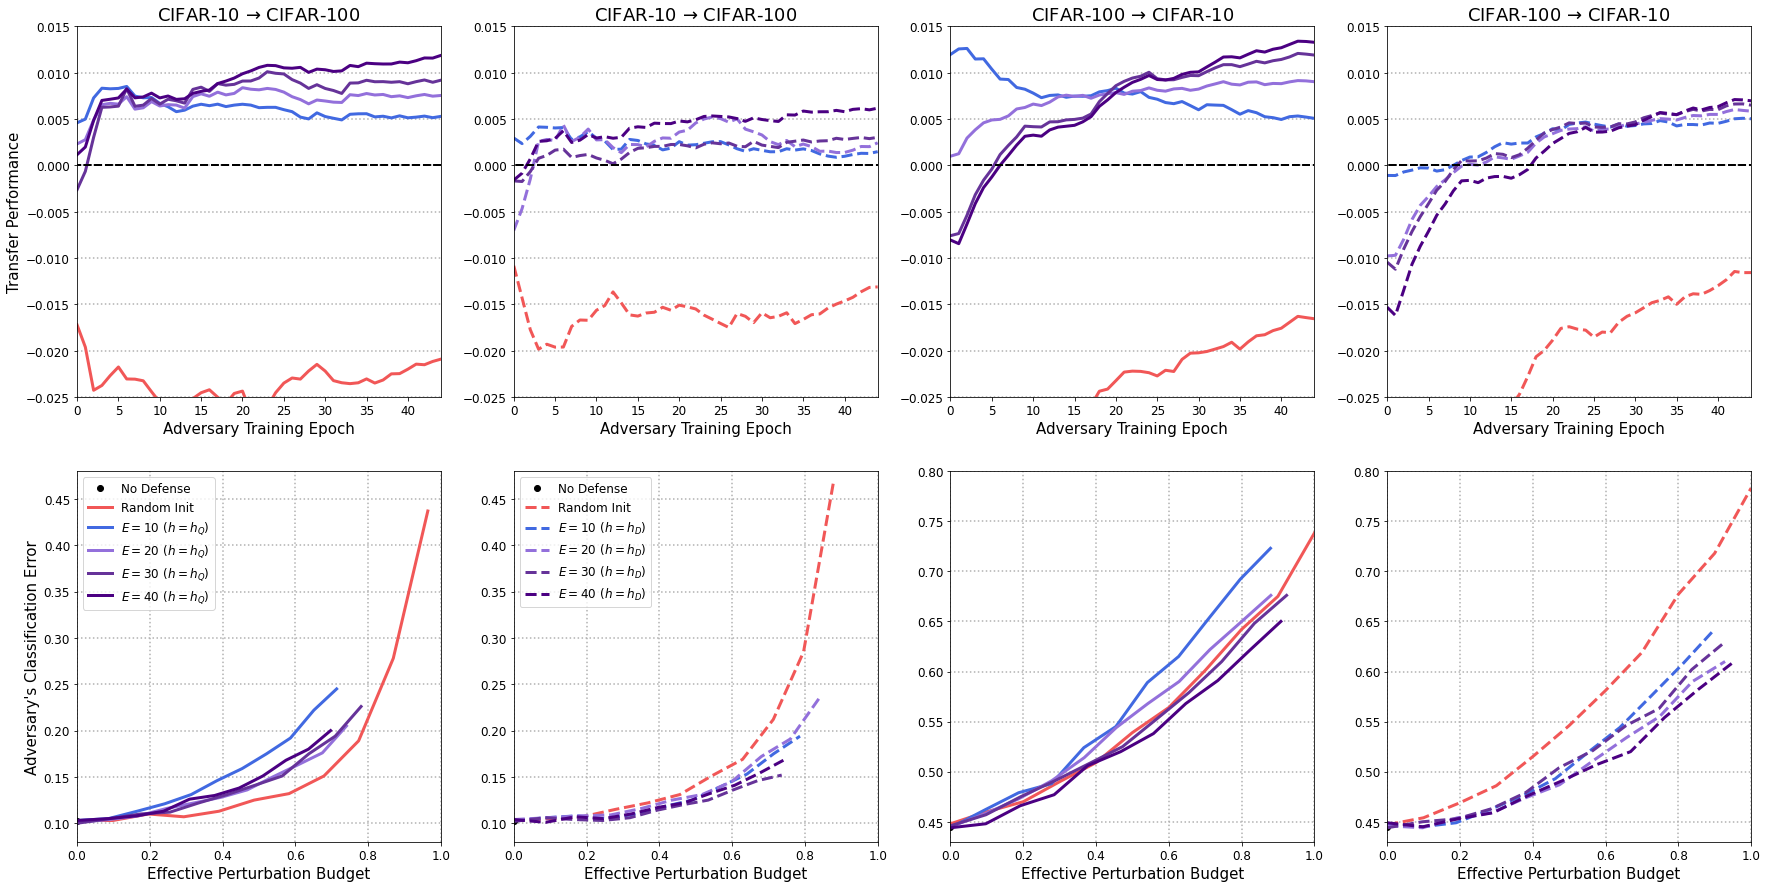

In [91]:
# _s1 corresponds to surrogate models that were trained with the defender's training distribution (h_D)
# as opposed to the query distribution (h_Q). These results are in Figure 8 of the paper.

eval_data_to_transfer_data = {
    'cifar10': ['cifar100'],
    'cifar100': ['cifar10'],
}

defense_to_label = {
    'None': 'No Defense',
    'ALL-ONES_0': 'Random Init',
    'ALL-ONES_10': r'$E=10$ ($h=h_Q$)',
    'ALL-ONES_20': r'$E=20$ ($h=h_Q$)',
    'ALL-ONES_30': r'$E=30$ ($h=h_Q$)',
    'ALL-ONES_40': r'$E=40$ ($h=h_Q$)',
    'ALL-ONES_0_s1': 'Random Init',
    'ALL-ONES_10_s1': r'$E=10$ ($h=h_D$)',
    'ALL-ONES_20_s1': r'$E=20$ ($h=h_D$)',
    'ALL-ONES_30_s1': r'$E=30$ ($h=h_D$)',
    'ALL-ONES_40_s1': r'$E=40$ ($h=h_D$)'
}

defense_to_color = {
    'None': 'black',
    'ALL-ONES_0': '#F15757',
    'ALL-ONES_10': 'royalblue',
    'ALL-ONES_20': 'mediumpurple',
    'ALL-ONES_30': 'rebeccapurple',
    'ALL-ONES_40': 'indigo',
    'ALL-ONES_0_s1': '#F15757',
    'ALL-ONES_10_s1': 'royalblue',
    'ALL-ONES_20_s1': 'mediumpurple',
    'ALL-ONES_30_s1': 'rebeccapurple',
    'ALL-ONES_40_s1': 'indigo'
}

dataset_to_string = {
    'cifar10': 'CIFAR-10',
    'cifar100': 'CIFAR-100',
    'cub200': 'CUB200',
    'caltech256': 'Caltech-256',
    'imagenet_cifar10': 'ImageNet-C10',
    'imagenet_cifar100': 'ImageNet-C100',
    'imagenet_cub200': 'ImageNet-CUB200'
}


fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(30,15))

for i, eval_data in enumerate(['cifar10', 'cifar100']):
    for defense in surrogate_results.keys():
        if defense not in ['ALL-ONES_0', 'ALL-ONES_10', 'ALL-ONES_20', 'ALL-ONES_30', 'ALL-ONES_40']:
            continue
        keys = list(surrogate_results[defense][eval_data].keys())
        keys = np.array(keys)[:-6]
        vals = [surrogate_results[defense][eval_data][k]['mean'] for k in surrogate_results[defense][eval_data].keys()]
        vals = moving_average(np.array(vals))
        ax[0,2*i].plot(keys, vals, label=defense_to_label[defense], c=defense_to_color[defense], lw=3)
        ax[0,2*i].plot([-10, 60], [0, 0], '--', c='black', lw=2)
        ax[0,2*i].set_xlim(0, 44)
        ax[0,2*i].set_ylim(-0.025, 0.015)
    ax[0,2*i].set_xlabel('Adversary Training Epoch', fontsize=15)
    if i == 0:
        ax[0,2*i].set_ylabel('Transfer Performance', fontsize=15)
#     ax[0,2*i].legend(fontsize=12)
    ax[0,2*i].grid(linestyle='dotted', axis='y', lw=1.5)
    ax[0,2*i].tick_params(axis='both', which='major', labelsize=12)
    ax[0,2*i].set_title(r'{} $\to$ {}'.format(dataset_to_string[eval_data],
                                              dataset_to_string[eval_data_to_transfer_data[eval_data][0]]),
                        fontsize=18)


    for defense in surrogate_results_s1.keys():
        if defense not in ['ALL-ONES_0_s1', 'ALL-ONES_10_s1', 'ALL-ONES_20_s1', 'ALL-ONES_30_s1', 'ALL-ONES_40_s1']:
            continue
        keys = list(surrogate_results_s1[defense][eval_data].keys())
        keys = np.array(keys)[:-6]
        vals = [surrogate_results_s1[defense][eval_data][k]['mean'] for k in surrogate_results_s1[defense][eval_data].keys()]
        vals = moving_average(np.array(vals))
        ax[0,2*i+1].plot(keys, vals, '--', label=defense_to_label[defense], c=defense_to_color[defense], lw=3)
        ax[0,2*i+1].plot([-10, 60], [0, 0], '--', c='black', lw=2)
        ax[0,2*i+1].set_xlim(0, 44)
        ax[0,2*i+1].set_ylim(-0.025, 0.015)
    ax[0,2*i+1].set_xlabel('Adversary Training Epoch', fontsize=15)
#     ax[0,2*i+1].set_ylabel('Transfer performance')
#     ax[0,2*i+1].legend(fontsize=12)
    ax[0,2*i+1].grid(linestyle='dotted', axis='y', lw=1.5)
    ax[0,2*i+1].tick_params(axis='both', which='major', labelsize=12)
    ax[0,2*i+1].set_title(r'{} $\to$ {}'.format(dataset_to_string[eval_data],
                                                dataset_to_string[eval_data_to_transfer_data[eval_data][0]]),
                          fontsize=18)



for i, eval_data in enumerate(['cifar10', 'cifar100']):
    transfer_data = eval_data_to_transfer_data[eval_data][0]
    print(eval_data, transfer_data)
    for j, metric in enumerate(['e_eps']):
        for k, suffix in enumerate(['', '_s1']):
            for defense in results[eval_data][transfer_data]:
                # use suffix to select s1 defenses
                if suffix == '_s1':
                    if '_s1' not in defense and defense != 'None':
                        continue
                else:
                    if '_s1' in defense:
                        continue
                
                if defense == 'teacher':
                    pass
                    #plt.plot(0, results[eval_data]['teacher'], 'o', label='teacher')
                elif defense == 'None':
                    ax[1+j, 2*i+k].plot(results[eval_data][transfer_data][defense][metric],
                                        results[eval_data][transfer_data][defense]['a_err'],
                                        'o',
                                        label=defense_to_label[defense],
                                        c=defense_to_color[defense], lw=3)
                else:
                    ax[1+j, 2*i+k].plot(results[eval_data][transfer_data][defense][metric],
                                        results[eval_data][transfer_data][defense]['a_err'],
                                        '--' if '_s1' in defense else '-',
                                        label=defense_to_label[defense],
                                        c=defense_to_color[defense], lw=3)

            if i == 0:
                ax[1+j, 2*i+k].legend(fontsize=12)
            if metric == 'e_eps':
                ax[1+j, 2*i+k].set_xlabel('Effective Perturbation Budget', fontsize=15)
                ax[1+j, 2*i+k].set_xlim(0, 1)
            elif metric == 'd_err':
                ax[1+j, 2*i+k].set_xlabel('Defender\'s Classification Error', fontsize=12)
            elif metric == 'd_calib_err':
                ax[1+j, 2*i+k].set_xlabel('Defender\'s Calibration Error', fontsize=12)
            elif metric == 'd_avg_err':
                ax[1+j, 2*i+k].set_xlabel('Defender\'s Combined Error', fontsize=12)

            if i == 0 and k == 0:
                ax[1+j, 2*i+k].set_ylabel('Adversary\'s Classification Error', fontsize=15)

            if eval_data == 'cub200':
                ax[1+j, 2*i+k].set_title('CUB200', fontsize=15)
            elif eval_data == 'cifar10':
#                 ax[1+j, 2*i+k].set_title('Transfer from CIFAR-100 to CIFAR-10', fontsize=15)
                ax[1+j, 2*i+k].set_ylim(0.08, 0.48)
            elif eval_data == 'cifar100':
#                 ax[1+j, 2*i+k].set_title('Transfer from CIFAR-10 to CIFAR-100', fontsize=15)
                ax[1+j, 2*i+k].set_ylim(0.43, 0.80)
            ax[1+j, 2*i+k].grid(linestyle='dotted', axis='both', lw=1.5)
            ax[1+j, 2*i+k].tick_params(axis='both', which='major', labelsize=12)

plt.savefig('./figures/surrogate_analysis.pdf', bbox_inches='tight')
plt.show()

# Table results

In [274]:
table_results = {}

for eval_data in ['cifar100']:
    table_results[eval_data] = {}
    for transfer_data in eval_data_to_transfer_data[eval_data]:
        table_results[eval_data][transfer_data] = {}
        for metric in ['d_err', 'e_eps']:
            baseline_metric = results[eval_data][transfer_data]['None'][metric][0]
            baseline_adv_err = 1 - results[eval_data][transfer_data]['None']['a_err'][0]  # converting to error

            table_results[eval_data][transfer_data][metric] = {}
            table_results[eval_data][transfer_data][metric]['None'] = {1.0: (baseline_metric, baseline_adv_err)}
            for defense in ['Random', 'ReverseSigmoid', 'AdaptiveMisinformation', 'MAD', 'ALL-ONES_10']:
    #         for defense in ['MAD', 'ALL-ONES_focused', 'ALL-ONES', 'ALL-ONES_10', 'ALL-ONES_10_focused1',
    #                         'ALL-ONES_10_focused2', 'ALL-ONES_10_focused3', 'ALL-ONES_10_focused4', 'ALL-ONES_10_focused5']:
                table_results[eval_data][transfer_data][metric][defense] = {}

                keys = results[eval_data][transfer_data][defense][metric]
                values = results[eval_data][transfer_data][defense]['a_err']

                if metric == 'd_err':
                    metric_multipliers = [0.01, 0.02, 0.05]
                elif metric == 'd_calib_err':
                    metric_multipliers = [0.01, 0.05, 0.1]
                elif metric == 'd_avg_err':
                    metric_multipliers = [1.1, 1.5, 2.0]
                elif metric == 'e_eps':
                    metric_multipliers = [0.1, 0.2, 0.5]
                for metric_multiplier in metric_multipliers:
                    target_metric = baseline_metric + metric_multiplier
                    # find the segment to interpolate
                    interpolation = None
                    print(eval_data, defense, len(keys), len(values))
                    for j in range(len(keys) - 1):
                        if keys[j] <= target_metric <= keys[j+1]:
                            m = (values[j + 1] - values[j]) / (keys[j + 1] - keys[j])
                            b = (values[j + 1] + values[j] - (m * (keys[j + 1] + keys[j]))) / 2
                            interpolation = m * target_metric + b
                            break
                    if type(target_metric) == torch.Tensor:
                        target_metric = target_metric.item()
                    if type(interpolation) == torch.Tensor:
                        interpolation = interpolation.item()
                    table_results[eval_data][transfer_data][metric][defense][metric_multiplier] = (target_metric, interpolation)

cifar100 Random 11 11
cifar100 Random 11 11
cifar100 Random 11 11
cifar100 ReverseSigmoid 11 11
cifar100 ReverseSigmoid 11 11
cifar100 ReverseSigmoid 11 11
cifar100 AdaptiveMisinformation 20 20
cifar100 AdaptiveMisinformation 20 20
cifar100 AdaptiveMisinformation 20 20
cifar100 MAD 11 11
cifar100 MAD 11 11
cifar100 MAD 11 11
cifar100 ALL-ONES_10 11 11
cifar100 ALL-ONES_10 11 11
cifar100 ALL-ONES_10 11 11
cifar100 Random 11 11
cifar100 Random 11 11
cifar100 Random 11 11
cifar100 ReverseSigmoid 11 11
cifar100 ReverseSigmoid 11 11
cifar100 ReverseSigmoid 11 11
cifar100 AdaptiveMisinformation 20 20
cifar100 AdaptiveMisinformation 20 20
cifar100 AdaptiveMisinformation 20 20
cifar100 MAD 11 11
cifar100 MAD 11 11
cifar100 MAD 11 11
cifar100 ALL-ONES_10 11 11
cifar100 ALL-ONES_10 11 11
cifar100 ALL-ONES_10 11 11


In [290]:
defenses = ['Random', 'ReverseSigmoid', 'AdaptiveMisinformation', 'MAD', 'ALL-ONES_10']
for defense in defenses:
    print(defense)

for eval_data in table_results:
    transfer_data = eval_data_to_transfer_data[eval_data][0]
    print(f'# ====================== {transfer_data} -> {eval_data} ====================== #')
    for metric in table_results[eval_data][transfer_data]:
        print(f'# ============= {metric} ============= #')
        for defense in defenses:
            tmp = [x[1] for x in list(table_results[eval_data][transfer_data][metric][defense].values())]
            vals = []
            for x in tmp:
                if x is not None:
                    vals.append(x)
                else:
                    vals.append('-')
            print(*vals)

Random
ReverseSigmoid
AdaptiveMisinformation
MAD
ALL-ONES_10
# ====================== imagenet_cifar10 -> cifar10 ====================== #
# ============= d_err ============= #
0.7179979085922241 0.7967928051948547 0.8835593461990356
- - -
0.2934812307357788 0.4711800813674927 0.8206796646118164
0.7325843572616577 0.8248449563980103 0.9020057916641235
0.5267870426177979 0.6241356730461121 0.6490215063095093
# ============= e_eps ============= #
0.1 0.2 0.5
0.1 0.2 0.5
0.1 0.2 0.5
0.1 0.2 0.5
0.1 0.2 0.5
# ====================== imagenet_cifar100 -> cifar100 ====================== #
# ============= d_err ============= #
0.5108635425567627 0.6016038656234741 0.7029534578323364
1.7916781902313232 1.797562837600708 1.8152167797088623
0.2609438896179199 0.43885231018066406 0.7410273551940918
0.5101008415222168 0.603678822517395 0.7029125094413757
0.4838395118713379 0.5773882865905762 0.7117278575897217
# ============= e_eps ============= #
0.1 0.2 0.5
0.1 0.2 0.5
- 0.2 0.5
0.1 0.2 0.5
0.1 0

In [275]:
defenses = ['Random', 'ReverseSigmoid', 'AdaptiveMisinformation', 'MAD', 'ALL-ONES_10']
for defense in defenses:
    print(defense)

for eval_data in table_results:
    transfer_data = eval_data_to_transfer_data[eval_data][0]
    print(f'# ====================== {transfer_data} -> {eval_data} ====================== #')
    for metric in table_results[eval_data][transfer_data]:
        print(f'# ============= {metric} ============= #')
        for defense in defenses:
            tmp = [x[1] for x in list(table_results[eval_data][transfer_data][metric][defense].values())]
            vals = []
            for x in tmp:
                if x is not None:
                    vals.append(x)
                else:
                    vals.append('-')
            print(*vals)

Random
ReverseSigmoid
AdaptiveMisinformation
MAD
ALL-ONES_10
# ====================== imagenet_cifar100 -> cifar100 ====================== #
# ============= d_err ============= #
0.385127454996109 0.3864201307296753 0.39805305004119873
0.9531984329223633 0.9607575535774231 0.9834346771240234
0.3820939064025879 0.40555667877197266 0.4661126732826233
0.43014127016067505 0.4678461253643036 0.49195152521133423
0.43443387746810913 0.47606658935546875 0.5296666622161865
# ============= e_eps ============= #
0.3620110478296286 0.3650073652247094 0.38501841356595745
0.36333532032681554 0.36763420201796254 0.37987156797942273
0.3643505862330966 0.3743762739054732 0.4177576274545354
0.359000000178818 0.3689999967217453 0.42600000000000005
0.3651491417824486 0.37675394458574296 0.44071582034211065


# Surrogate transfer experiments

Here, we compute per-example gradients. This is for checking whether the perturbations designed to modify the gradients of a surrogate network actually transfer to the adversary network. Using opacus allows us to parallelize the computation of per-example gradients, greatly speeding up the experiments without changing the results (I checked). This required nontrivial modifications to work with ResNets, such as manually replacing batch norm. You can treat it as a black box that does the same thing as iterating through examples one-by-one and computing gradients wrt the parameters of the network.

Note: This is only used for checking whether the GRAD^2 surrogates work as intended.

In [9]:
class ZippedDataset(torch.utils.data.Dataset):
        def __init__(self, datasets):
            super().__init__()
            self.datasets = datasets
            assert np.all([len(x) == len(datasets[0]) for x in datasets]), 'Should have same length'
    
        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            return tuple(x[idx] for x in self.datasets)

In [10]:
class BatchNormReplacement(torch.nn.Module):
    def __init__(self, bn):
        super().__init__()
        num_features = bn.num_features
        conv = torch.nn.Conv2d(num_features, num_features, 1)
        conv.bias.data = bn.bias.data
        conv.weight.data = torch.diag(bn.weight.data).unsqueeze(-1).unsqueeze(-1)
        self.conv = conv
        self.running_mean = bn.running_mean.data.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        self.running_var = bn.running_var.data.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        self.eps = bn.eps
        
    def forward(self, x):
        out = (x - self.running_mean) / (self.running_var + self.eps).pow(0.5)
        out = self.conv(out)
        return out

In [11]:
def replace_bn(m, name):
    for attr_str in dir(m):
        target_attr = getattr(m, attr_str)
        if type(target_attr) == torch.nn.BatchNorm2d:
#             print('replaced: ', name, attr_str)
            replacement = BatchNormReplacement(target_attr)
            replacement.train(target_attr.training)
            setattr(m, attr_str, replacement)
    for n, ch in m.named_children():
        replace_bn(ch, n)

In [12]:
def collect_grad_sample(model, recurse = True):
        """
        Same thing as nn.Module.parameters, but replaces bn1.conv.weight and bn2.conv.weight with 
        their diagonals
        """
        all_grad = []
        for name, param in model.named_parameters(recurse=recurse):
            bsize = param.grad_sample.shape[0]
            if 'bn1.conv.weight' in name or 'bn2.conv.weight' in name:
                tmp = torch.eye(param.shape[0]).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
                tmp = tmp.repeat(bsize, 1, 1, 1, 1).bool()
                all_grad.append(param.grad_sample.detach().data[tmp].view(bsize, -1))
            else:
                all_grad.append(param.grad_sample.detach().data.view(bsize, -1))
        
        return torch.cat(all_grad, dim=-1)

In [13]:
def get_Gty_grad_sample(bx, student, y):
    """
    computes G^T y, where y is the posterior used in cross-entropy loss
    
    same functionality as get_Gtx, but more efficient and with different arguments
    
    Works with student_pred of shape (N, K)
    
    :param bx: a batch of image inputs (CIFAR or ImageNet in our experiments)
    :param student: student network
    :param y: posterior to be used for cross-entropy loss
    :returns: G^T y, a 1D tensor with length equal to the number of params in backprop_modules
    """
    logits = student(bx)
    normalized_logits = logits - torch.logsumexp(logits, dim=1, keepdim=True)

    # cross-entropy loss
    loss = (y * normalized_logits).sum(1).mean(0)
    student.zero_grad()
    student.del_grad_sample()
    for p in student.parameters():
        if hasattr(p, "activations") and p.activations is not None:
            if p.activations.grad_fn is not None:
                p.activations.detach_()
            else:
                p.activations.requires_grad_(False)
            del p.activations
    loss.backward()

In [14]:
def evaluate_surrogate_transfer(data_with_posteriors, adversary,
                                mode='ALL-ONES', opacus=False):
    """
    :param data_with_posteriors: a zipped dataset of the inputs, control posteriors, and method posteriors
    :param adversary: the adversary to test transfer on
    :param mode: string controlling eval mode; should be in ['MIN-IP', 'ALL-ONES', 'MAX-NORM',
        'RandomDirection1', 'RandomDirection2', 'RandomDirection3']
    :param opacus: use opacus for batching the per-sample gradient computation
    """
    control_sims = []
    method_sims = []
    sim_diffs = []
    perturbation_sizes = []
    
    batch_size = 200 if opacus else 1
    data_loader = torch.utils.data.DataLoader(data_with_posteriors,
                                              batch_size=batch_size)
    
    for (bx, by), posterior_control, posterior_method in data_loader:
        bx = bx.cuda()
        posterior_control = torch.FloatTensor(posterior_control).cuda()
        posterior_method = torch.FloatTensor(posterior_method).cuda()
        tmp = (posterior_control - posterior_method).abs().sum(1)
        perturbation_sizes.extend(list(tmp.detach().cpu().numpy()))

        #
        if opacus:
            get_Gty_grad_sample(bx, adversary, posterior_control)
            clean_grad = collect_grad_sample(adversary)
        else:
            clean_grad = get_Gty(bx, adversary, posterior_control, create_graph=False)
        
#         # TESTING
#         teacher = load_model('cifar10', 10)
#         root_path = 'your-path-here/model-stealing-defenses/batch_training/outputs/trained_models/adversary_intermediate'
#         transfer_data = 'cifar100'
#         eval_data = 'cifar10'
#         epoch = 0
#         teacher_path = f'{root_path}/{transfer_data}_to_{eval_data}_None_eps0.0_{epoch}epochs.pt'
#         assert os.path.exists(teacher_path), 'Expected model in teacher path: {}'.format(teacher_path)
#         teacher.load_state_dict(torch.load(teacher_path))
#         teacher.eval()
        
#         print((adversary(bx) - teacher(bx)).abs().max())
#         print(teacher(bx).abs().max())
#         print(adversary(bx).abs().max())
#         for idx in range(1):
#             teacher_clean_grad = get_Gty(bx[idx].unsqueeze(0), teacher, posterior_control[idx].unsqueeze(0))
#             print((clean_grad[idx] - teacher_clean_grad).abs().max(), (clean_grad[idx] - teacher_clean_grad).abs().mean())
#             print(teacher_clean_grad.abs().max(), teacher_clean_grad.abs().mean())
#             print(clean_grad[idx].abs().max(), clean_grad[idx].abs().mean())
#             print()
#             tmp = (clean_grad[idx] - teacher_clean_grad).detach().cpu().numpy()
#             plt.figure(figsize=(6,6))
#             plt.hist(tmp, bins=1000)
#             plt.xlim(-1 * 1e-7, 1e-7)
#             plt.show()
#         assert False, 'Chuck Testa'
#         # END TESTING
        
        if mode == 'MIN-IP':
            target_grad = clean_grad.detach().clone()  # for MIN-IP
        elif mode == 'ALL-ONES':
            target_grad = torch.ones_like(clean_grad)  # for ALL-ONES
        elif mode == 'MAX-NORM':
            target_grad = adversary_params  # for MAX-NORM (not implemented yet)
        elif mode in ['RandomDirection1', 'RandomDirection2', 'RandomDirection3']:
            seed = int(mode[-1])
            rng = np.random.RandomState(seed)
            target_grad = torch.FloatTensor(rng.randn(clean_grad.shape[-1])).cuda()
            target_grad = target_grad.unsqueeze(0).repeat(clean_grad.shape[0], 1)
        else:
            assert False, f'bad value of mode: {mode}'
        
        denom = clean_grad.view(batch_size, -1).norm(p=2, dim=1) * \
                target_grad.view(batch_size, -1).norm(p=2, dim=1)
        control_sim = (clean_grad * target_grad).sum(1) / denom
        #
        if opacus:
            get_Gty_grad_sample(bx, adversary, posterior_method)
            pert_grad = collect_grad_sample(adversary)
        else:
            pert_grad = get_Gty(bx, adversary, posterior_method, create_graph=False)
        
        denom = pert_grad.view(batch_size, -1).norm(p=2, dim=1) * \
                target_grad.view(batch_size, -1).norm(p=2, dim=1)
        method_sim = (pert_grad * target_grad).sum(1) / denom    

        control_sims.extend(list(control_sim.detach().cpu().numpy()))
        method_sims.extend(list(method_sim.detach().cpu().numpy()))
        sim_diffs.extend(list((method_sim - control_sim).detach().cpu().numpy()))
    
    return control_sims, method_sims, sim_diffs, perturbation_sizes

In [ ]:
# Compute similarity to target

surrogate_results = {}

# for defense in tqdm(['ALL-ONES_0_s1', 'ALL-ONES_10_s1', 'ALL-ONES_20_s1', 'ALL-ONES_30_s1', 'ALL-ONES_40_s1']):
for defense in tqdm(['ALL-ONES_0', 'ALL-ONES_10', 'ALL-ONES_20', 'ALL-ONES_30', 'ALL-ONES_40']):
    print(f'# ========== Defense: {defense} ========== #')
    surrogate_results[defense] = {}

    root_path = 'your-path-here/model-stealing-defenses/batch_training/outputs/trained_models/adversary_intermediate'
    for eval_data in ['cifar10', 'cifar100']:
        surrogate_results[defense][eval_data] = {}
        if eval_data == 'cifar10':
            transfer_data = 'cifar100'
            num_classes = 10
        elif eval_data == 'cifar100':
            transfer_data = 'cifar10'
            num_classes = 100

        # ====================== Get The Data ====================== #
        transfer_data_deterministic, _ = load_data(transfer_data, train=True, deterministic=True)
        with open(f'../outputs/generated_perturbations/{transfer_data}_to_{eval_data}_None.pkl', 'rb') as f:
            posteriors_control = pickle.load(f)['0.0']
        with open(f'../outputs/generated_perturbations/{transfer_data}_to_{eval_data}_{defense}.pkl', 'rb') as f:
            posteriors_method = pickle.load(f)['0.5']
        tmp_data = ZippedDataset([transfer_data_deterministic, posteriors_control, posteriors_method])
        shuffle_indices = np.arange(len(transfer_data_deterministic))
        rng = np.random.default_rng(1)
        rng.shuffle(shuffle_indices)
        data_with_posteriors = torch.utils.data.Subset(tmp_data, shuffle_indices[:1000])

        for epoch in range(0, 51, 1):
            surrogate_results[defense][eval_data][epoch] = {}
            for run in [1, 2, 3]:
                surrogate_results[defense][eval_data][epoch][run] = {}

                model = load_model(eval_data, num_classes, drop_rate=0).cuda()
                model_path = f'{root_path}/{transfer_data}_to_{eval_data}_None_eps0.0_run{run}_{epoch}epochs.pt'
                if os.path.exists(model_path) == False:
                    print('Expected model in path: {}; skipping'.format(model_path))
                    continue
                model.load_state_dict(torch.load(model_path))
                model.eval()

                # =================== opacus grad sample setup =================== #
                replace_bn(model, "net")
                model.train()

                model = opacus.grad_sample.grad_sample_module.GradSampleModule(
                    model, batch_first=True, loss_reduction='mean')
                # =================== ^ opacus grad sample setup ^ =================== #

                out = evaluate_surrogate_transfer(data_with_posteriors, model, mode='RandomDirection2',
                                                  opacus=True)

                model._close()  # clean up after opacus

                sim_diffs = out[2]
                perturbation_sizes = out[3]
                #print('mean and var pert sizes:', np.mean(perturbation_sizes), np.var(perturbation_sizes))
                #surrogate_results[defense][eval_data][epoch][run]['all'] = out
                surrogate_results[defense][eval_data][epoch][run]['mean'] = np.mean(sim_diffs)
            surrogate_results[defense][eval_data][epoch]['mean'] = np.mean([surrogate_results[defense][eval_data][epoch][x]['mean'] for x in [1]])


  0%|          | 0/5 [00:00<?, ?it/s]

# ========== Defense: ALL-ONES_0 ========== #
Files already downloaded and verified


/home/mantas3/anaconda3/envs/pytorch17/lib/python3.8/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Files already downloaded and verified



 20%|██        | 1/5 [43:21<2:53:26, 2601.53s/it]

# ========== Defense: ALL-ONES_10 ========== #
Files already downloaded and verified
Files already downloaded and verified



 40%|████      | 2/5 [1:25:00<2:08:32, 2570.71s/it]

# ========== Defense: ALL-ONES_20 ========== #
Files already downloaded and verified
Files already downloaded and verified


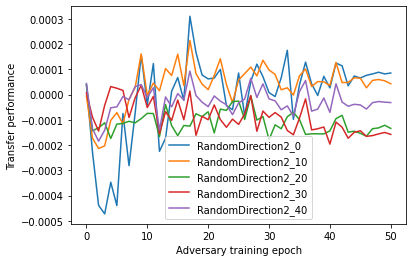

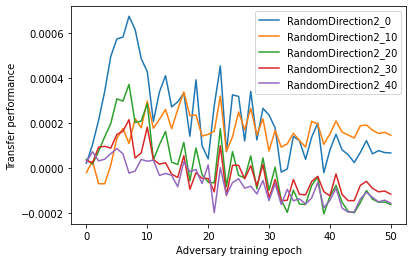

In [14]:
# averaged results (across 3 adversaries) with non-s1 surrogates
plt.figure()
for defense in surrogate_results.keys():
    if defense not in ['RandomDirection2_0', 'RandomDirection2_10', 'RandomDirection2_20', 'RandomDirection2_30',
                       'RandomDirection2_40']:
        continue
    plt.plot(list(surrogate_results[defense]['cifar10'].keys()),
             [surrogate_results[defense]['cifar10'][k]['mean'] for k in surrogate_results[defense]['cifar10'].keys()],
             label=defense)
plt.xlabel('Adversary training epoch')
plt.ylabel('Transfer performance')
plt.legend()
plt.show()

plt.figure()
for defense in surrogate_results.keys():
    if defense not in ['RandomDirection2_0', 'RandomDirection2_10', 'RandomDirection2_20', 'RandomDirection2_30',
                       'RandomDirection2_40']:
        continue
    plt.plot(list(surrogate_results[defense]['cifar100'].keys()),
             [surrogate_results[defense]['cifar100'][k]['mean'] for k in surrogate_results[defense]['cifar100'].keys()],
             label=defense)
plt.xlabel('Adversary training epoch')
plt.ylabel('Transfer performance')
plt.legend()
plt.show()

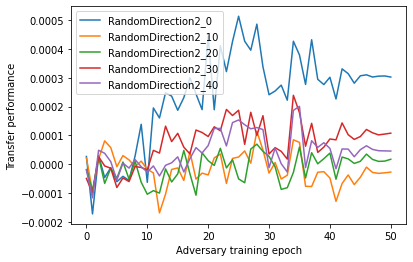

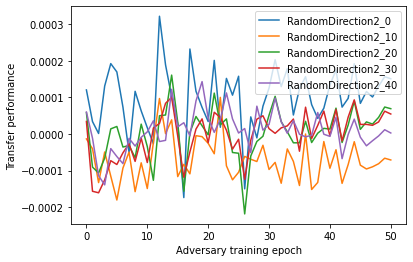

In [10]:
# averaged results (across 3 adversaries) with non-s1 surrogates
plt.figure()
for defense in surrogate_results.keys():
    if defense not in ['RandomDirection2_0', 'RandomDirection2_10', 'RandomDirection2_20', 'RandomDirection2_30',
                       'RandomDirection2_40']:
        continue
    plt.plot(list(surrogate_results[defense]['cifar10'].keys()),
             [surrogate_results[defense]['cifar10'][k]['mean'] for k in surrogate_results[defense]['cifar10'].keys()],
             label=defense)
plt.xlabel('Adversary training epoch')
plt.ylabel('Transfer performance')
plt.legend()
plt.show()

plt.figure()
for defense in surrogate_results.keys():
    if defense not in ['RandomDirection2_0', 'RandomDirection2_10', 'RandomDirection2_20', 'RandomDirection2_30',
                       'RandomDirection2_40']:
        continue
    plt.plot(list(surrogate_results[defense]['cifar100'].keys()),
             [surrogate_results[defense]['cifar100'][k]['mean'] for k in surrogate_results[defense]['cifar100'].keys()],
             label=defense)
plt.xlabel('Adversary training epoch')
plt.ylabel('Transfer performance')
plt.legend()
plt.show()

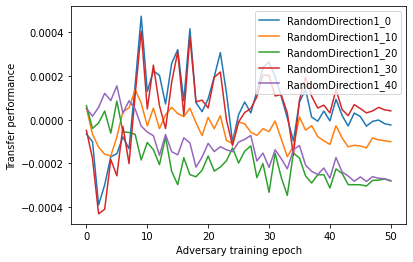

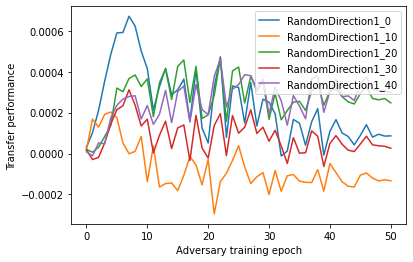

In [11]:
# averaged results (across 3 adversaries) with non-s1 surrogates
plt.figure()
for defense in surrogate_results.keys():
    if defense not in ['RandomDirection1_0', 'RandomDirection1_10', 'RandomDirection1_20', 'RandomDirection1_30',
                       'RandomDirection1_40']:
        continue
    plt.plot(list(surrogate_results[defense]['cifar10'].keys()),
             [surrogate_results[defense]['cifar10'][k]['mean'] for k in surrogate_results[defense]['cifar10'].keys()],
             label=defense)
plt.xlabel('Adversary training epoch')
plt.ylabel('Transfer performance')
plt.legend()
plt.show()

plt.figure()
for defense in surrogate_results.keys():
    if defense not in ['RandomDirection1_0', 'RandomDirection1_10', 'RandomDirection1_20', 'RandomDirection1_30',
                       'RandomDirection1_40']:
        continue
    plt.plot(list(surrogate_results[defense]['cifar100'].keys()),
             [surrogate_results[defense]['cifar100'][k]['mean'] for k in surrogate_results[defense]['cifar100'].keys()],
             label=defense)
plt.xlabel('Adversary training epoch')
plt.ylabel('Transfer performance')
plt.legend()
plt.show()

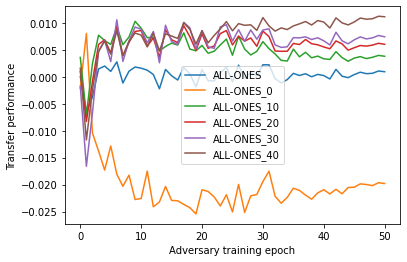

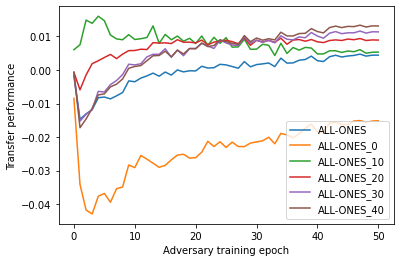

In [35]:
# averaged results (across 3 adversaries) with non-s1 surrogates
plt.figure()
for defense in surrogate_results.keys():
    if defense not in ['ALL-ONES_0', 'ALL-ONES_10', 'ALL-ONES_20', 'ALL-ONES_30', 'ALL-ONES_40', 'ALL-ONES']:
        continue
    plt.plot(list(surrogate_results[defense]['cifar10'].keys()),
             [surrogate_results[defense]['cifar10'][k]['mean'] for k in surrogate_results[defense]['cifar10'].keys()],
             label=defense)
plt.xlabel('Adversary training epoch')
plt.ylabel('Transfer performance')
plt.legend()
plt.show()

plt.figure()
for defense in surrogate_results.keys():
    if defense not in ['ALL-ONES_0', 'ALL-ONES_10', 'ALL-ONES_20', 'ALL-ONES_30', 'ALL-ONES_40', 'ALL-ONES']:
        continue
    plt.plot(list(surrogate_results[defense]['cifar100'].keys()),
             [surrogate_results[defense]['cifar100'][k]['mean'] for k in surrogate_results[defense]['cifar100'].keys()],
             label=defense)
plt.xlabel('Adversary training epoch')
plt.ylabel('Transfer performance')
plt.legend()
plt.show()

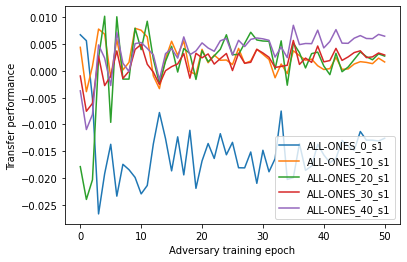

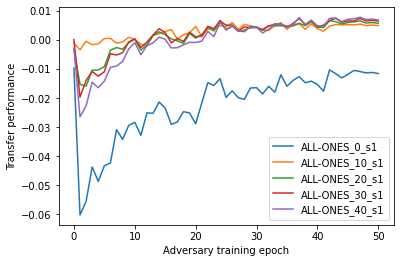

In [18]:
# averaged results (across 3 adversaries) with s1 surrogates
plt.figure()
for defense in surrogate_results.keys():
    plt.plot(list(surrogate_results[defense]['cifar10'].keys()),
             [surrogate_results[defense]['cifar10'][k]['mean'] for k in surrogate_results[defense]['cifar10'].keys()],
             label=defense)
plt.xlabel('Adversary training epoch')
plt.ylabel('Transfer performance')
plt.legend()
plt.show()

plt.figure()
for defense in surrogate_results.keys():
    plt.plot(list(surrogate_results[defense]['cifar100'].keys()),
             [surrogate_results[defense]['cifar100'][k]['mean'] for k in surrogate_results[defense]['cifar100'].keys()],
             label=defense)
plt.xlabel('Adversary training epoch')
plt.ylabel('Transfer performance')
plt.legend()
plt.show()

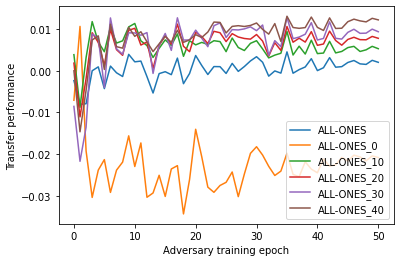

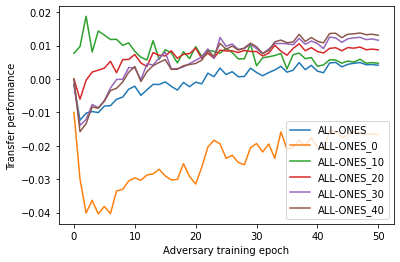

In [34]:
# individual results with non-s1 surrogates
plt.figure()
for defense in surrogate_results1.keys():
    if defense not in ['ALL-ONES_0', 'ALL-ONES_10', 'ALL-ONES_20', 'ALL-ONES_30', 'ALL-ONES_40', 'ALL-ONES']:
        continue
    plt.plot(list(surrogate_results1[defense]['cifar10'].keys()),
             [surrogate_results1[defense]['cifar10'][k]['mean'] for k in surrogate_results1[defense]['cifar10'].keys()],
             label=defense)
plt.xlabel('Adversary training epoch')
plt.ylabel('Transfer performance')
plt.legend()
plt.show()

plt.figure()
for defense in surrogate_results1.keys():
    if defense not in ['ALL-ONES_0', 'ALL-ONES_10', 'ALL-ONES_20', 'ALL-ONES_30', 'ALL-ONES_40', 'ALL-ONES']:
        continue
    plt.plot(list(surrogate_results1[defense]['cifar100'].keys()),
             [surrogate_results1[defense]['cifar100'][k]['mean'] for k in surrogate_results1[defense]['cifar100'].keys()],
             label=defense)
plt.xlabel('Adversary training epoch')
plt.ylabel('Transfer performance')
plt.legend()
plt.show()

In [36]:
torch.save(surrogate_results, 'surrogate_results.pkl')

In [ ]:
# These results were computed in a separate notebook using a copy of the code above.
# Hence, we load them in. You could also recompute them using the code above.

surrogate_results = torch.load('./surrogate_results_new.pt')
surrogate_results_s1 = torch.load('./surrogate_results_new_s1.pt')

In [5]:
def moving_average(a, n=7) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

cifar10 cifar100
cifar100 cifar10


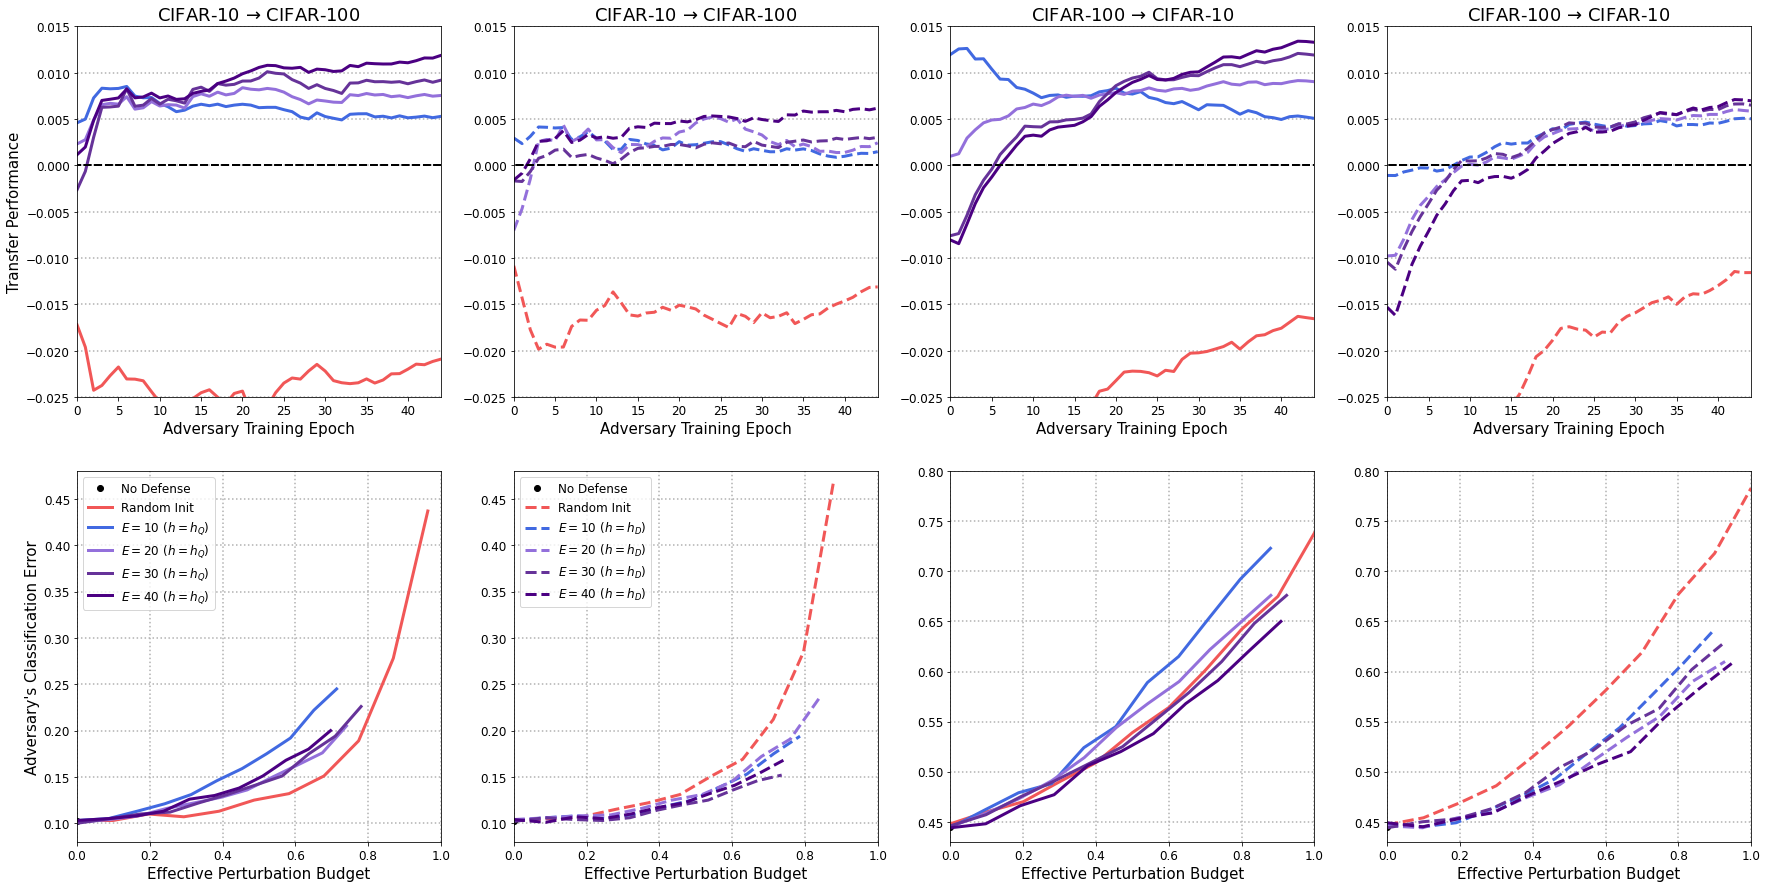

In [91]:
# _s1 corresponds to surrogate models that were trained with the defender's training distribution (h_D)
# as opposed to the query distribution (h_Q). These results are in Figure 8 of the paper.

eval_data_to_transfer_data = {
    'cifar10': ['cifar100'],
    'cifar100': ['cifar10'],
}

defense_to_label = {
    'None': 'No Defense',
    'ALL-ONES_0': 'Random Init',
    'ALL-ONES_10': r'$E=10$ ($h=h_Q$)',
    'ALL-ONES_20': r'$E=20$ ($h=h_Q$)',
    'ALL-ONES_30': r'$E=30$ ($h=h_Q$)',
    'ALL-ONES_40': r'$E=40$ ($h=h_Q$)',
    'ALL-ONES_0_s1': 'Random Init',
    'ALL-ONES_10_s1': r'$E=10$ ($h=h_D$)',
    'ALL-ONES_20_s1': r'$E=20$ ($h=h_D$)',
    'ALL-ONES_30_s1': r'$E=30$ ($h=h_D$)',
    'ALL-ONES_40_s1': r'$E=40$ ($h=h_D$)'
}

defense_to_color = {
    'None': 'black',
    'ALL-ONES_0': '#F15757',
    'ALL-ONES_10': 'royalblue',
    'ALL-ONES_20': 'mediumpurple',
    'ALL-ONES_30': 'rebeccapurple',
    'ALL-ONES_40': 'indigo',
    'ALL-ONES_0_s1': '#F15757',
    'ALL-ONES_10_s1': 'royalblue',
    'ALL-ONES_20_s1': 'mediumpurple',
    'ALL-ONES_30_s1': 'rebeccapurple',
    'ALL-ONES_40_s1': 'indigo'
}

dataset_to_string = {
    'cifar10': 'CIFAR-10',
    'cifar100': 'CIFAR-100',
    'cub200': 'CUB200',
    'caltech256': 'Caltech-256',
    'imagenet_cifar10': 'ImageNet-C10',
    'imagenet_cifar100': 'ImageNet-C100',
    'imagenet_cub200': 'ImageNet-CUB200'
}


fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(30,15))

for i, eval_data in enumerate(['cifar10', 'cifar100']):
    for defense in surrogate_results.keys():
        if defense not in ['ALL-ONES_0', 'ALL-ONES_10', 'ALL-ONES_20', 'ALL-ONES_30', 'ALL-ONES_40']:
            continue
        keys = list(surrogate_results[defense][eval_data].keys())
        keys = np.array(keys)[:-6]
        vals = [surrogate_results[defense][eval_data][k]['mean'] for k in surrogate_results[defense][eval_data].keys()]
        vals = moving_average(np.array(vals))
        ax[0,2*i].plot(keys, vals, label=defense_to_label[defense], c=defense_to_color[defense], lw=3)
        ax[0,2*i].plot([-10, 60], [0, 0], '--', c='black', lw=2)
        ax[0,2*i].set_xlim(0, 44)
        ax[0,2*i].set_ylim(-0.025, 0.015)
    ax[0,2*i].set_xlabel('Adversary Training Epoch', fontsize=15)
    if i == 0:
        ax[0,2*i].set_ylabel('Transfer Performance', fontsize=15)
#     ax[0,2*i].legend(fontsize=12)
    ax[0,2*i].grid(linestyle='dotted', axis='y', lw=1.5)
    ax[0,2*i].tick_params(axis='both', which='major', labelsize=12)
    ax[0,2*i].set_title(r'{} $\to$ {}'.format(dataset_to_string[eval_data],
                                              dataset_to_string[eval_data_to_transfer_data[eval_data][0]]),
                        fontsize=18)


    for defense in surrogate_results_s1.keys():
        if defense not in ['ALL-ONES_0_s1', 'ALL-ONES_10_s1', 'ALL-ONES_20_s1', 'ALL-ONES_30_s1', 'ALL-ONES_40_s1']:
            continue
        keys = list(surrogate_results_s1[defense][eval_data].keys())
        keys = np.array(keys)[:-6]
        vals = [surrogate_results_s1[defense][eval_data][k]['mean'] for k in surrogate_results_s1[defense][eval_data].keys()]
        vals = moving_average(np.array(vals))
        ax[0,2*i+1].plot(keys, vals, '--', label=defense_to_label[defense], c=defense_to_color[defense], lw=3)
        ax[0,2*i+1].plot([-10, 60], [0, 0], '--', c='black', lw=2)
        ax[0,2*i+1].set_xlim(0, 44)
        ax[0,2*i+1].set_ylim(-0.025, 0.015)
    ax[0,2*i+1].set_xlabel('Adversary Training Epoch', fontsize=15)
#     ax[0,2*i+1].set_ylabel('Transfer performance')
#     ax[0,2*i+1].legend(fontsize=12)
    ax[0,2*i+1].grid(linestyle='dotted', axis='y', lw=1.5)
    ax[0,2*i+1].tick_params(axis='both', which='major', labelsize=12)
    ax[0,2*i+1].set_title(r'{} $\to$ {}'.format(dataset_to_string[eval_data],
                                                dataset_to_string[eval_data_to_transfer_data[eval_data][0]]),
                          fontsize=18)



for i, eval_data in enumerate(['cifar10', 'cifar100']):
    transfer_data = eval_data_to_transfer_data[eval_data][0]
    print(eval_data, transfer_data)
    for j, metric in enumerate(['e_eps']):
        for k, suffix in enumerate(['', '_s1']):
            for defense in results[eval_data][transfer_data]:
                # use suffix to select s1 defenses
                if suffix == '_s1':
                    if '_s1' not in defense and defense != 'None':
                        continue
                else:
                    if '_s1' in defense:
                        continue
                
                if defense == 'teacher':
                    pass
                    #plt.plot(0, results[eval_data]['teacher'], 'o', label='teacher')
                elif defense == 'None':
                    ax[1+j, 2*i+k].plot(results[eval_data][transfer_data][defense][metric],
                                        results[eval_data][transfer_data][defense]['a_err'],
                                        'o',
                                        label=defense_to_label[defense],
                                        c=defense_to_color[defense], lw=3)
                else:
                    ax[1+j, 2*i+k].plot(results[eval_data][transfer_data][defense][metric],
                                        results[eval_data][transfer_data][defense]['a_err'],
                                        '--' if '_s1' in defense else '-',
                                        label=defense_to_label[defense],
                                        c=defense_to_color[defense], lw=3)

            if i == 0:
                ax[1+j, 2*i+k].legend(fontsize=12)
            if metric == 'e_eps':
                ax[1+j, 2*i+k].set_xlabel('Effective Perturbation Budget', fontsize=15)
                ax[1+j, 2*i+k].set_xlim(0, 1)
            elif metric == 'd_err':
                ax[1+j, 2*i+k].set_xlabel('Defender\'s Classification Error', fontsize=12)
            elif metric == 'd_calib_err':
                ax[1+j, 2*i+k].set_xlabel('Defender\'s Calibration Error', fontsize=12)
            elif metric == 'd_avg_err':
                ax[1+j, 2*i+k].set_xlabel('Defender\'s Combined Error', fontsize=12)

            if i == 0 and k == 0:
                ax[1+j, 2*i+k].set_ylabel('Adversary\'s Classification Error', fontsize=15)

            if eval_data == 'cub200':
                ax[1+j, 2*i+k].set_title('CUB200', fontsize=15)
            elif eval_data == 'cifar10':
#                 ax[1+j, 2*i+k].set_title('Transfer from CIFAR-100 to CIFAR-10', fontsize=15)
                ax[1+j, 2*i+k].set_ylim(0.08, 0.48)
            elif eval_data == 'cifar100':
#                 ax[1+j, 2*i+k].set_title('Transfer from CIFAR-10 to CIFAR-100', fontsize=15)
                ax[1+j, 2*i+k].set_ylim(0.43, 0.80)
            ax[1+j, 2*i+k].grid(linestyle='dotted', axis='both', lw=1.5)
            ax[1+j, 2*i+k].tick_params(axis='both', which='major', labelsize=12)

plt.savefig('./figures/surrogate_analysis.pdf', bbox_inches='tight')
plt.show()

# Watermarking

In [5]:
import sys
sys.path.insert(0, 'your-path-here/model-stealing-defenses/batch_training')
from wrn import WideResNet
from utils import get_watermark_batch, load_model
from torchvision import datasets, transforms
import numpy as np

In [6]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

In [141]:
transfer_data = 'cifar10'
eval_data = 'cifar100'
num_classes = 100
seed = 3

if eval_data == 'cifar100':
    test_data = datasets.CIFAR100('./data', train=False, transform=test_transform, download=False)
elif eval_data == 'cifar10':
    test_data = datasets.CIFAR10('./data', train=False, transform=test_transform, download=False)

watermark_bx, watermark_by = get_watermark_batch(test_data, num_classes, num_watermarks=1, seed=seed)

In [118]:
shuffle_indices = np.arange(len(test_data))
np.random.shuffle(shuffle_indices)
tmp_test_data = torch.utils.data.Subset(test_data, shuffle_indices[:1000])
test_loader = torch.utils.data.DataLoader(tmp_test_data, batch_size=32, num_workers=4, pin_memory=True)

In [119]:
def get_posteriors(model, loader):
    model.eval()
    running_acc = 0
    count = 0
    posteriors = []
    
    for i, (bx, by) in enumerate(loader):
        bx = bx.cuda()
        by = by.cuda()
        logits = model(bx)

        running_acc += (logits.argmax(dim=1) == by).float().sum(0).item()
        count += by.shape[0]
        posteriors.append(torch.softmax(logits, dim=1).cpu())
    
    acc = running_acc / count
    posteriors = torch.cat(posteriors, dim=0)
    
    return acc, posteriors

In [142]:
root = 'your-path-here/model-stealing-defenses/batch_training/outputs/trained_models'
defense = 'WATERMARK'

epsilons = ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
outputs = []
outputs1 = []
outputs2 = []

for epsilon in epsilons:
    save_path = os.path.join(root, f'{transfer_data}_to_{eval_data}_oracle{defense}_eps{epsilon}_{seed}.pt')

    model = load_model('cifar100', 100)
    model_path = save_path
    assert os.path.exists(model_path), 'Expected model in model path: {}'.format(model_path)
    model.load_state_dict(torch.load(model_path))
    model.eval();

    with torch.no_grad():
        out = torch.softmax(model(watermark_bx), dim=1)
    
    output = (out * watermark_by).sum(1).item()
    outputs.append(output)
    
    watermark_label = watermark_by[0].argmax().cpu()
    with torch.no_grad():
        acc, posteriors = get_posteriors(model, test_loader)
    output1 = posteriors[:, watermark_label].mean(0).item()
    outputs1.append(output1)
    tmp = posteriors[:, (1-watermark_by.squeeze(0)).bool()]
    output2 = tmp.mean(1).mean(0).item()
    outputs2.append(output2)
    
    print(epsilon, output, output1, output2)

0.1 0.007711865473538637 0.013416120782494545 0.009965494275093079
0.2 0.09733329713344574 0.030255893245339394 0.009795394726097584
0.3 0.06390627473592758 0.03320888802409172 0.009765567258000374
0.4 0.17240168154239655 0.06602338701486588 0.009434106759727001
0.5 0.2088322937488556 0.12735801935195923 0.00881456583738327
0.6 0.03266313672065735 0.02579829841852188 0.009840420447289944
0.7 0.12261083722114563 0.0675697773694992 0.00941848661750555
0.8 0.40748023986816406 0.24044159054756165 0.007672307081520557
0.9 0.039356887340545654 0.05774443969130516 0.009517733007669449
1.0 0.29715609550476074 0.26085713505744934 0.007466088980436325


In [136]:
all_outputs = []
all_outputs1 = []
all_outputs2 = []

In [143]:
all_outputs.append(outputs)
all_outputs1.append(outputs1)
all_outputs2.append(outputs2)

In [71]:
watermark_results = {'cifar100': [], 'cifar10': []}

In [78]:
watermark_results['cifar100'].append(outputs)

In [25]:
watermark_results['cifar10'].append(outputs)

In [37]:
torch.save(watermark_results, './watermark_results.pt')

In [45]:
watermark_results = torch.load('watermark_results.pt')

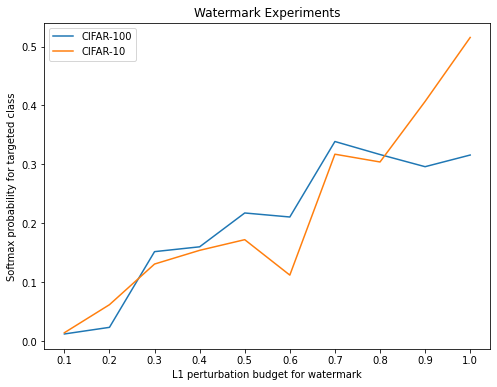

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(epsilons, np.array(watermark_results['cifar100']).mean(0), label='CIFAR-100')
plt.plot(epsilons, np.array(watermark_results['cifar10']).mean(0), label='CIFAR-10')
plt.legend()
plt.xlabel('L1 perturbation budget for watermark')
plt.ylabel('Softmax probability for targeted class')
plt.title('Watermark Experiments')
plt.show()

/srv/condor/execute/dir_5216/ipykernel_11644/3825369996.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(epsilons, np.array(watermark_results['cifar100']).mean(0), label='CIFAR-100')


ValueError: x and y must have same first dimension, but have shapes (10,) and (28,)

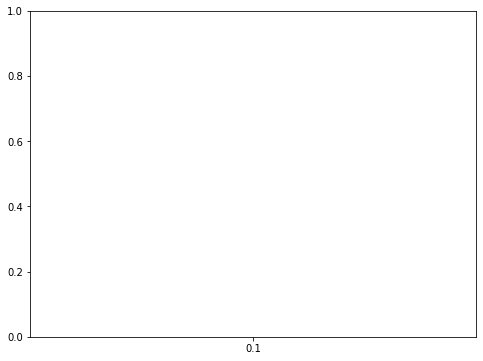

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(epsilons, np.array(watermark_results['cifar100']).mean(0), label='CIFAR-100')
# plt.plot(epsilons, np.array(watermark_results['cifar10']).mean(0), label='CIFAR-10')
plt.legend()
plt.xlabel('L1 perturbation budget for watermark')
plt.ylabel('Softmax probability for targeted class')
plt.title('Watermark Experiments')
plt.show()

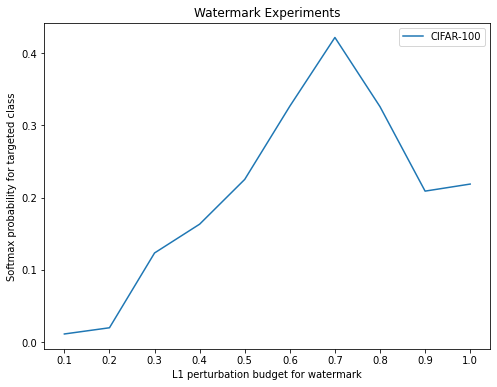

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(epsilons, np.array(watermark_results['cifar100']).mean(0), label='CIFAR-100')
# plt.plot(epsilons, np.array(watermark_results['cifar10']).mean(0), label='CIFAR-10')
plt.legend()
plt.xlabel('L1 perturbation budget for watermark')
plt.ylabel('Softmax probability for targeted class')
plt.title('Watermark Experiments')
plt.show()

In [40]:
np.array(watermark_results['cifar100'])

/srv/condor/execute/dir_5216/ipykernel_11644/1522177255.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(watermark_results['cifar100'])[0]


[0.004994875751435757,
 0.022667894139885902,
 0.23652540147304535,
 0.1909550577402115,
 0.654732882976532,
 0.40124738216400146,
 0.556563138961792,
 0.1427099108695984]

In [83]:
to_plot

[0.019299696975698073,
 0.07863571060200532,
 0.165567380686601,
 0.19498792787392935,
 0.32355792075395584,
 0.29246923327445984,
 0.40889466802279156,
 0.21679086486498514,
 0.0363615769892931,
 0.18533991277217865]

In [ ]:
color_dict = {
    'None': 'black',
    'Random': '#E79556',
    'ReverseSigmoid': 'brown',
    'AdaptiveMisinformation': '#9043C3',
    'MAD': '#F15757',
    'ALL-ONES_10': 'royalblue'
}

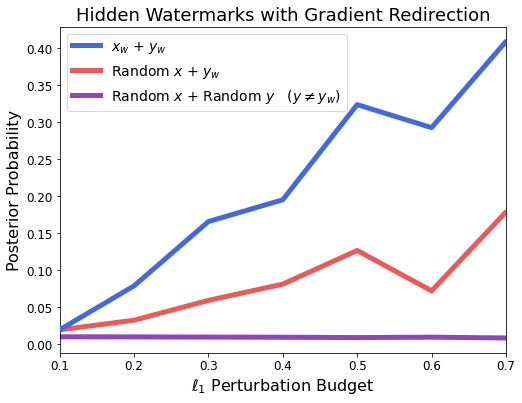

In [187]:
plt.figure(figsize=(8, 6))
to_plot = [[] for i in range(10)]
for j in range(3):
    for i, v in enumerate(all_outputs[j]):
        to_plot[i].append(v)
to_plot_mean = np.array([np.mean(x) for x in to_plot])
to_plot_std = np.array([np.std(x) for x in to_plot])

to_plot1 = [[] for i in range(10)]
for j in range(3):
    for i, v in enumerate(all_outputs1[j]):
        to_plot1[i].append(v)
to_plot1_mean = np.array([np.mean(x) for x in to_plot1])
to_plot1_std = np.array([np.std(x) for x in to_plot1])

to_plot2 = [[] for i in range(10)]
for j in range(3):
    for i, v in enumerate(all_outputs2[j]):
        to_plot2[i].append(v)
to_plot2_mean = np.array([np.mean(x) for x in to_plot2])
to_plot2_std = np.array([np.std(x) for x in to_plot2])

xs = [float(x) for x in epsilons]

plt.plot(xs, to_plot_mean, label=r'$x_w$ + $y_w$', lw=5, c='royalblue', zorder=100)
# plt.fill_between(xs, to_plot_mean-to_plot_std, to_plot_mean+to_plot_std)
                 
plt.plot(xs, to_plot1_mean, label=r'Random $x$ + $y_w$', lw=5, c='#F15757')
# plt.fill_between(xs, to_plot1_mean-to_plot1_std, to_plot1_mean+to_plot1_std)

plt.plot(xs, to_plot2_mean, label=r'Random $x$ + Random $y$   ($y \neq y_w$)', lw=5, c='#9043C3')
# plt.fill_between(xs, to_plot2_mean-to_plot2_std, to_plot2_mean+to_plot2_std)
plt.legend(fontsize=14)

plt.xlabel(r'$\ell_1$ Perturbation Budget', fontsize=16)
plt.ylabel('Posterior Probability', fontsize=16)
plt.title('Hidden Watermarks with Gradient Redirection', fontsize=18)
plt.xlim(0.1, 0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('./figures/watermark.pdf', bbox_inches='tight')
plt.show()

In [5]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32,
                                          num_workers=3, shuffle=False, pin_memory=True)

In [6]:
def evaluate(model, loader):
    running_loss = 0
    running_acc = 0
    count = 0
    all_preds = []
    
    for i, (bx, by) in enumerate(loader):
        bx = bx.cuda()
        by = by.cuda()
        logits = model(bx)
        smax = torch.softmax(logits, dim=1)
        all_preds.append(smax.detach().cpu())
        loss = F.cross_entropy(logits, by, reduction='sum')
        
        running_loss += loss.item()
        running_acc += (logits.argmax(dim=1) == by).float().sum(0).item()
        count += by.shape[0]
    
    loss = running_loss / count
    acc = running_acc / count
    
    return loss, acc, all_preds

In [19]:
loss, acc, all_preds = evaluate(model, test_loader)

In [10]:
watermark_results = torch.load('./watermark_results.pt')

In [20]:
tmp = watermark_by.argmax().item()
tmp2 = [all_preds[i][tmp] for i in range(len(all_preds))]

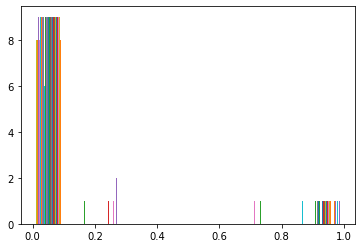

In [21]:
plt.figure()
plt.hist(tmp2)
plt.show()

## Testing Reverse Sigmoid

This is for checking our implementation of the reverse sigmoid baseline.

In [118]:
def method_reverse_sigmoid(bx, teacher, student=None, epsilons=[0.0, 0.0025, 0.005, 0.01, 0.02, 0.04, 0.08, 0.16], gamma=0.2):
    """
    :param bx: input batch of tensors for teacher and student networks
    :param teacher: teacher network, outputs logits
    :param student: list of students (None for reverse sigmoid)
    :param epsilons: a list of beta parameters in the reverse sigmoid method (named epsilon for convenience)
    :param gamma: the gamma parameter in the reverse sigmoid method
    :returns: unperturbed posterior
    """
    betas = epsilons  # renaming for clarity

    # get clean posterior
    with torch.no_grad():
        teacher_logits = teacher(bx)
        teacher_pred = torch.softmax(teacher_logits, dim=1)
    

    all_outs = []
    # for each beta, perturb the posterior with the reverse sigmoid method
    for beta in betas:
        logits = torch.log(torch.clamp(teacher_pred / (1 - teacher_pred), min=1e-12, max=1-1e-12))
        z = gamma * logits
        r = beta * (torch.sigmoid(z) - 0.5)
        out = teacher_pred - r
        out = out / out.sum(-1).unsqueeze(-1)
        out = out.unsqueeze(1)  # adding dimension for beta
        all_outs.append(out)
    
    all_outs = torch.cat(all_outs, dim=1)

    return all_outs.detach()

In [119]:
with torch.no_grad():
    out = torch.softmax(model(watermark_bx), dim=1)
print(out)

tensor([[3.0782e-03, 7.2867e-06, 4.5147e-04, 1.0314e-01, 8.5079e-03, 2.0199e-04,
         5.9015e-05, 7.1071e-05, 1.6269e-04, 1.5538e-05, 2.6418e-04, 1.5836e-04,
         7.3789e-04, 3.7733e-04, 2.0664e-05, 1.3286e-02, 7.2724e-05, 4.4725e-04,
         3.7716e-05, 3.7068e-03, 1.2083e-05, 2.3449e-04, 1.7541e-04, 6.3171e-05,
         1.6171e-05, 8.5044e-04, 6.5451e-04, 2.6923e-02, 8.2338e-05, 4.3019e-04,
         2.2202e-04, 2.6147e-04, 1.3327e-03, 5.7707e-05, 1.5478e-03, 4.2806e-05,
         3.2896e-04, 2.5293e-04, 7.6693e-04, 1.1555e-04, 5.5783e-05, 2.7015e-05,
         8.3195e-03, 1.7334e-03, 5.3084e-03, 4.5837e-05, 2.3201e-04, 2.2695e-05,
         3.2508e-04, 9.6675e-05, 2.7193e-04, 4.4766e-04, 4.9252e-05, 4.6069e-06,
         8.8033e-06, 5.2067e-02, 1.1432e-05, 1.4407e-04, 2.4749e-03, 1.9368e-04,
         3.8232e-05, 1.6293e-04, 7.5042e-06, 1.1524e-03, 6.9996e-03, 1.2196e-03,
         1.6475e-03, 2.5704e-04, 4.0469e-05, 9.1315e-05, 4.7992e-06, 1.2922e-04,
         7.1879e-01, 2.9093e

In [120]:
out = method_reverse_sigmoid(watermark_bx, model)

In [127]:
print(out[:,7,:])

tensor([[0.0071, 0.0105, 0.0083, 0.0191, 0.0070, 0.0088, 0.0095, 0.0094, 0.0089,
         0.0102, 0.0086, 0.0090, 0.0080, 0.0084, 0.0101, 0.0073, 0.0094, 0.0083,
         0.0098, 0.0070, 0.0103, 0.0087, 0.0089, 0.0095, 0.0102, 0.0079, 0.0080,
         0.0086, 0.0093, 0.0083, 0.0087, 0.0086, 0.0076, 0.0095, 0.0075, 0.0097,
         0.0085, 0.0087, 0.0079, 0.0091, 0.0096, 0.0099, 0.0070, 0.0074, 0.0069,
         0.0097, 0.0087, 0.0100, 0.0085, 0.0093, 0.0086, 0.0083, 0.0096, 0.0107,
         0.0104, 0.0118, 0.0103, 0.0090, 0.0072, 0.0088, 0.0098, 0.0089, 0.0105,
         0.0077, 0.0069, 0.0076, 0.0074, 0.0087, 0.0097, 0.0093, 0.0107, 0.0091,
         0.1140, 0.0086, 0.0080, 0.0082, 0.0100, 0.0090, 0.0084, 0.0090, 0.0069,
         0.0089, 0.0101, 0.0107, 0.0089, 0.0070, 0.0091, 0.0085, 0.0077, 0.0087,
         0.0083, 0.0092, 0.0102, 0.0072, 0.0094, 0.0090, 0.0096, 0.0069, 0.0099,
         0.0101]], device='cuda:0')


# Visualizing gradient redirection perf

In [245]:
from defenses import *

In [246]:
student = load_model('cifar100', 100).eval()
student.load_state_dict(torch.load('../outputs/trained_models/cifar10_to_cifar100_surrogate_10epochs.pt'))
teacher = load_model('cifar100', 100).eval()
teacher.load_state_dict(torch.load('../outputs/trained_models/cifar100_teacher.pt'))

<All keys matched successfully>

In [247]:
test_data, _ = load_data('cifar10', train=False, deterministic=True)

Files already downloaded and verified


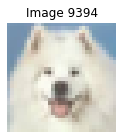






Getting grad of distillation loss wrt student params.
Getting metrics for random perturbations.
Getting metrics for the Orekondy et al. method
Getting metrics for our algorithm.


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

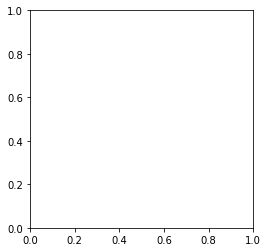

In [248]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

saved_results = []
baseline_times = []
mad_times = []
our_times = []

shuffle_indices = np.arange(len(test_data))
np.random.seed(0)
np.random.shuffle(shuffle_indices)

for inp_idx in range(100):
    print('\n\n\n\nCollecting metrics for image {}\n'.format(inp_idx))
    plt.figure(figsize=(2,2))
    plt.imshow((test_data[shuffle_indices[inp_idx]][0].permute(1,2,0) + 1) / 2)
    plt.title('Image {}'.format(shuffle_indices[inp_idx]))
    plt.axis('off')
    plt.show()
    print('\n\n\n\n')
    
    inp = test_data[shuffle_indices[inp_idx]][0].cuda().unsqueeze(0)
    label = test_data[shuffle_indices[inp_idx]][1]
    
    # ==================== GET GRAD OF DISTILLATION LOSS WRT STUDENT PARAMS ==================== #
    print('Getting grad of distillation loss wrt student params.')
    
    student.zero_grad()
    teacher.zero_grad()
    
    start.record()
    with torch.no_grad():
        teacher_pred = torch.softmax(teacher(inp), dim=1)
    end.record()
    torch.cuda.synchronize()
    baseline_times.append(start.elapsed_time(end))
    student_grad_orig = get_Gty(inp, student, teacher_pred, create_graph=False)
    
    
    # ==================== RANDOM PERTURBATIONS TO POSTERIOR ==================== #
    print('Getting metrics for random perturbations.')
    
    random_epsilon = []
    random_cos_dist = []
    random_inner_prod = []
    
    student.zero_grad()
    teacher.zero_grad()
    
    y_tilde_rand = method_rand_perturbation(inp, teacher, student,
                                            epsilons=np.linspace(0, 2, 41), num_classes=100)
    for i in range(41):
        teacher_pred_perturbed = y_tilde_rand[:,i,:]
        student_grad_perturbed = get_Gty(inp, student, teacher_pred_perturbed, create_graph=False)

        random_epsilon.append((teacher_pred - teacher_pred_perturbed).abs().sum())

        norm1 = student_grad_orig.norm(p=2)
        norm2 = student_grad_perturbed.norm(p=2)
        cosine_dist = 1 - ((student_grad_orig * student_grad_perturbed).sum() / (norm1 * norm2))
        random_cos_dist.append(cosine_dist.item())
        inner_prod = (student_grad_orig * student_grad_perturbed).sum()
        random_inner_prod.append(inner_prod.item())
    
    keys = random_epsilon
    values = random_cos_dist
    tmp = []
    for target_metric in np.linspace(0, 1, 21):
        # find the segment to interpolate
        interpolation = None
        for j in range(len(keys) - 1):
            if keys[j] <= target_metric <= keys[j+1]:
                m = (values[j + 1] - values[j]) / (keys[j + 1] - keys[j])
                b = (values[j + 1] + values[j] - (m * (keys[j + 1] + keys[j]))) / 2
                interpolation = m * target_metric + b
                break
        if interpolation is None:
            assert False, 'random results did not extend far enough: {}'.format(inp_idx)
        tmp.append(interpolation)
    random_cos_dist = tmp
    
    values = random_inner_prod
    tmp = []
    for target_metric in np.linspace(0, 1, 21):
        # find the segment to interpolate
        interpolation = None
        for j in range(len(keys) - 1):
            if keys[j] <= target_metric <= keys[j+1]:
                m = (values[j + 1] - values[j]) / (keys[j + 1] - keys[j])
                b = (values[j + 1] + values[j] - (m * (keys[j + 1] + keys[j]))) / 2
                interpolation = m * target_metric + b
                break
        if interpolation is None:
            assert False, 'random results did not extend far enough: {}'.format(inp_idx)
        tmp.append(interpolation)
    random_inner_prod = tmp
    random_epsilon = np.linspace(0, 1, 21)
    
    # ==================== OREKONDY PERTURBATIONS TO POSTERIOR ==================== #
    print('Getting metrics for the Orekondy et al. method')
    orekondy_epsilon = []
    orekondy_cos_dist = []
    orekondy_inner_prod = []
    
    
    student.zero_grad()
    teacher.zero_grad()
    
    start.record()
    y_tilde_mad = method_orekondy(inp, teacher, student, epsilons=np.linspace(0, 1, 21),
                                  backprop_modules=[student.module.fc])
    end.record()
    torch.cuda.synchronize()
    mad_times.append(start.elapsed_time(end))
    
    for i in range(21):
        teacher_pred_perturbed = y_tilde_mad[:,i,:]
        student_grad_perturbed = get_Gty(inp, student, teacher_pred_perturbed, create_graph=False)

        orekondy_epsilon.append((teacher_pred - teacher_pred_perturbed).abs().sum())

        norm1 = student_grad_orig.norm(p=2)
        norm2 = student_grad_perturbed.norm(p=2)
        cosine_dist = 1 - ((student_grad_orig * student_grad_perturbed).sum() / (norm1 * norm2))
        inner_prod = (student_grad_orig * student_grad_perturbed).sum()
        orekondy_cos_dist.append(cosine_dist.item())
        orekondy_inner_prod.append(inner_prod.item())
    
    # ==================== OUR PERTURBATIONS TO POSTERIOR ==================== #
    print('Getting metrics for our algorithm.')
    
    redirection_epsilon = []
    redirection_cos_dist = []
    redirection_inner_prod = []

    
    student.zero_grad()
    teacher.zero_grad()
    
    start.record()
    y_tilde_gr = method_gradient_redirection(inp, teacher, [student], epsilons=np.linspace(0, 1, 21),
                                        backprop_modules=None, override_grad=False)
    end.record()
    torch.cuda.synchronize()
    our_times.append(start.elapsed_time(end))
    
    for i in range(21):
        teacher_pred_perturbed = y_tilde_gr[:,i,:]
        student_grad_perturbed = get_Gty(inp, student, teacher_pred_perturbed, create_graph=False)

        redirection_epsilon.append((teacher_pred - teacher_pred_perturbed).abs().sum())

        norm1 = student_grad_orig.norm(p=2)
        norm2 = student_grad_perturbed.norm(p=2)
        cosine_dist = 1 - ((student_grad_orig * student_grad_perturbed).sum() / (norm1 * norm2))
        inner_prod = (student_grad_orig * student_grad_perturbed).sum()
        redirection_cos_dist.append(cosine_dist.item())
        redirection_inner_prod.append(inner_prod.item())
        
        
    plt.figure(figsize=(4,4))
    plt.plot(random_epsilon, random_inner_prod, 'o', color='blue', label='Random')
    plt.plot(orekondy_epsilon, orekondy_inner_prod, 'o-', color='orange', label='Orekondy et al.')
    plt.plot(redirection_epsilon, redirection_inner_prod, 'o-', color='green', label='Ours')
    plt.xlabel('epsilon')
    plt.ylabel('inner_prod(orig_grad, perturbed_grad)')
    plt.legend()
    plt.show()

    plt.figure(figsize=(4,4))
    plt.plot(random_epsilon, random_cos_dist, 'o', color='blue', label='Random')
    plt.plot(orekondy_epsilon, orekondy_cos_dist, 'o-', color='orange', label='Orekondy et al.')
    plt.plot(redirection_epsilon, redirection_cos_dist, 'o-', color='green', label='Ours')
    plt.xlabel('epsilon')
    plt.ylabel('cos_dist(orig_grad, perturbed_grad)')
    plt.legend()
    plt.show()

    saved_results.append([random_epsilon, random_inner_prod, random_cos_dist,
                          orekondy_epsilon, orekondy_inner_prod, orekondy_cos_dist,
                          redirection_epsilon, redirection_inner_prod, redirection_cos_dist])

In [249]:
color_dict = {
    'None': 'black',
    'Random': '#E79556',
    'ReverseSigmoid': 'brown',
    'AdaptiveMisinformation': '#9043C3',
    'MAD': '#F15757',
    'ALL-ONES_10': 'royalblue'
}

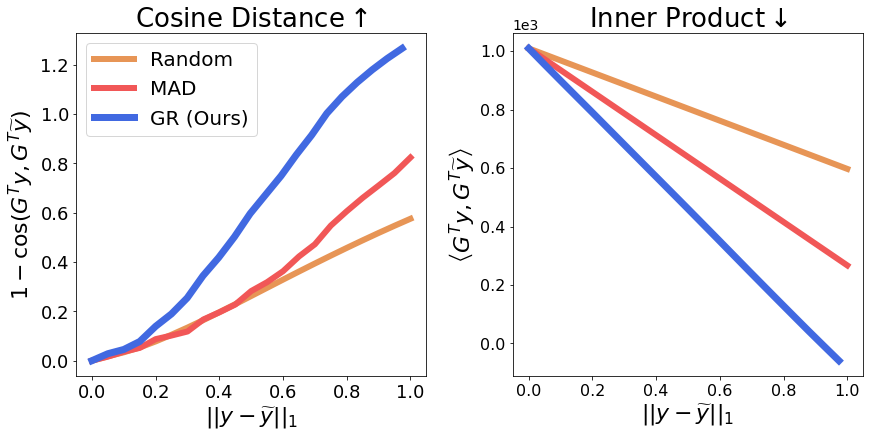

In [284]:
all_random_epsilon = []
all_random_cos_dist = []
all_orekondy_epsilon = []
all_orekondy_cos_dist = []
all_redirection_epsilon = []
all_redirection_cos_dist = []

for i in range(len(saved_results)):
    img_results = saved_results[i]
    all_random_epsilon.append(torch.FloatTensor(img_results[0]).unsqueeze(0))
    all_random_cos_dist.append(torch.FloatTensor(img_results[2]).unsqueeze(0))
    all_orekondy_epsilon.append(torch.FloatTensor(img_results[3]).unsqueeze(0))
    all_orekondy_cos_dist.append(torch.FloatTensor(img_results[5]).unsqueeze(0))
    all_redirection_epsilon.append(torch.FloatTensor(img_results[6]).unsqueeze(0))
    all_redirection_cos_dist.append(torch.FloatTensor(img_results[8]).unsqueeze(0))

all_random_epsilon = torch.cat(all_random_epsilon, dim=0)
all_random_cos_dist = torch.cat(all_random_cos_dist, dim=0)
all_orekondy_epsilon = torch.cat(all_orekondy_epsilon, dim=0)
all_orekondy_cos_dist = torch.cat(all_orekondy_cos_dist, dim=0)
all_redirection_epsilon = torch.cat(all_redirection_epsilon, dim=0)
all_redirection_cos_dist = torch.cat(all_redirection_cos_dist, dim=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
# plt.plot(all_random_epsilon.mean(0), all_random_cos_dist.mean(0), 'o', color='blue', label='Random')
ax[0].plot(all_random_epsilon.mean(0), all_random_cos_dist.mean(0), '-', linewidth=6, color='#E79556', label='Random')
ax[0].plot(all_orekondy_epsilon.mean(0), all_orekondy_cos_dist.mean(0), '-', linewidth=6, color='#F15757', label='MAD')
ax[0].plot(all_redirection_epsilon.mean(0), all_redirection_cos_dist.mean(0), '-', linewidth=7, color='royalblue', label='GR (Ours)')
ax[0].set_xlabel(r'$|| y - \widetilde{y} ||_1$', fontsize=22)
ax[0].set_ylabel(r'$1 - \cos( G^Ty, G^T \widetilde{y} )$', fontsize=22)
ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_title(r'Cosine Distance$\uparrow$', fontsize=26)
# plt.xlim(0,0.6)
# plt.ylim(0,0.4)
ax[0].legend(fontsize=20)







all_random_epsilon = []
all_random_inner_prod = []
all_orekondy_epsilon = []
all_orekondy_inner_prod = []
all_redirection_epsilon = []
all_redirection_inner_prod = []

for i in range(len(saved_results)):
    img_results = saved_results[i]
    all_random_epsilon.append(torch.FloatTensor(img_results[0]).unsqueeze(0))
    all_random_inner_prod.append(torch.FloatTensor(img_results[1]).unsqueeze(0))
    all_orekondy_epsilon.append(torch.FloatTensor(img_results[3]).unsqueeze(0))
    all_orekondy_inner_prod.append(torch.FloatTensor(img_results[4]).unsqueeze(0))
    all_redirection_epsilon.append(torch.FloatTensor(img_results[6]).unsqueeze(0))
    all_redirection_inner_prod.append(torch.FloatTensor(img_results[7]).unsqueeze(0))

all_random_epsilon = torch.cat(all_random_epsilon, dim=0)
all_random_inner_prod = torch.cat(all_random_inner_prod, dim=0)
all_orekondy_epsilon = torch.cat(all_orekondy_epsilon, dim=0)
all_orekondy_inner_prod = torch.cat(all_orekondy_inner_prod, dim=0)
all_redirection_epsilon = torch.cat(all_redirection_epsilon, dim=0)
all_redirection_inner_prod = torch.cat(all_redirection_inner_prod, dim=0)

# plt.plot(all_random_epsilon.mean(0), all_random_inner_prod.mean(0), 'o', color='blue', label='Random')
ax[1].plot(all_random_epsilon.mean(0), -1*all_random_inner_prod.mean(0), '-', linewidth=6, color='#E79556', label='Random')
ax[1].plot(all_orekondy_epsilon.mean(0), -1*all_orekondy_inner_prod.mean(0), '-', linewidth=6, color='#F15757', label='MAD')
ax[1].plot(all_redirection_epsilon.mean(0), -1*all_redirection_inner_prod.mean(0), '-', linewidth=7, color='royalblue', label='Gradient Redirection\n(Ours)')
ax[1].set_xlabel(r'$|| y - \widetilde{y} ||_1$', fontsize=22)
ax[1].set_ylabel(r'$\left<-G^Ty, G^T \widetilde{y}\right>$', fontsize=22)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].yaxis.get_offset_text().set_fontsize(14)
ax[1].set_title(r'Inner Product$\downarrow$', fontsize=26)
# plt.xlim(0, 0.6)
# plt.ylim(300, 820)
# plt.legend(fontsize=14)
plt.tight_layout(pad=0.4, w_pad=1.5, h_pad=3.0)
plt.savefig('./figures/surrogate_metrics.pdf', bbox_inches='tight')
plt.show()